In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines
import matplotlib as mpl

import sklearn
import os
import scipy
import glob
import string
import logomaker

from sklearn.metrics import r2_score
from scipy.optimize import curve_fit

from pathlib import Path
from statannotations.Annotator import Annotator
from matplotlib_venn import venn2

import Utils as ut
%matplotlib inline
ds_infos=pd.read_csv("Tables/Datasets_infos.tsv", sep="\t", index_col=0)

# F1 Acc Prec Rec

In [5]:
tot=pd.DataFrame(columns=["Accuracy","Precision","Recall","F1W","F1M","Dataset","FeaturesSpace","Name"])
for dataset, featurespace, label, name in zip(ds_infos["DSs"], ds_infos["FsSs"], ds_infos["LBs"], ds_infos["Names"]):
    data=pd.DataFrame(columns=tot.columns)
    path=f"Datasets/{dataset}/FeatureSpaces/{featurespace}/XAI/{dataset}_{featurespace}_GRAE_kNN_{label}_HPO"
    file=f"{path}_Predictions.tsv.gz"
    if os.path.isfile(file) == True:              
        df=pd.read_csv(file, sep="\t", index_col=0)
        df=df[df["GNN_set"]=="Test"]
        cfs[f"{dataset}_{featurespace}"]=pd.DataFrame(sklearn.metrics.confusion_matrix(df[label], df.GNN_prediction), columns=sorted(set(df[label])), index=sorted(set(df[label])))
        acc=np.around(df[df[label]==df["GNN_prediction"]].shape[0]/df.shape[0], decimals=4)
        f1=sklearn.metrics.precision_recall_fscore_support(df[label], df.GNN_prediction, average="weighted")
        f1m=sklearn.metrics.precision_recall_fscore_support(df[label], df.GNN_prediction, average="macro")[2]
        to_append=pd.DataFrame(index=data.columns, data=[acc]+[f for f in np.array(f1[:3])]+[f1m, dataset, featurespace, name]).T
        data=pd.concat([data, to_append])
        tot=pd.concat([tot, data])
    else:
       print(file)
tot["F1W"]=tot["F1W"].astype(float)
tot["Accuracy"]=tot["Accuracy"].astype(float)
tot["Precision"]=tot["Precision"].astype(float)
tot["Recall"]=tot["Recall"].astype(float)
tot.reset_index(inplace=True)
tot.drop("index", axis=1, inplace=True)
tot["FeaturesSpace"]=tot["FeaturesSpace"].replace("Peak","Peaks")
tot["FeaturesSpace"]=tot["FeaturesSpace"].replace("Window","Windows")
tot.to_csv("Tables/F1PrecRec.tsv.gz", sep="\t", compression="gzip")

#  Stability and Specificty

In [ ]:
tot=pd.DataFrame(columns=["Stability","Specificity","Dataset","FeaturesSpace", "CT", "Name"])
for dataset, featurespace, label, name in zip(ds_infos["DSs"], ds_infos["FsSs"], ds_infos["LBs"], ds_infos["Names"]):
    files=sorted(glob.glob(f"Datasets/{dataset}/FeatureSpaces/{featurespace}/XAI/{label}/{dataset}_{featurespace}_GRAE_kNN_{label}*Specificity.tsv.gz"))
    for file in files:
        data=pd.DataFrame(columns=tot.columns)  
        d=pd.read_csv(file, sep="\t", index_col=0)
        data.at[0, "Specificity"]=float(1-(d/50).median())
        data["Dataset"]=dataset
        data["FeaturesSpace"]=featurespace
        data["CT"]=str(d.columns[0])
        data["Name"]=name

        stab_file=f"Datasets/{dataset}/FeatureSpaces/{featurespace}/XAI/{label}/{dataset}_{featurespace}_GRAE_kNN_{label}_HPO_{str(d.columns[0])}_Stability.tsv.gz"
        d=pd.read_csv(stab_file, sep="\t", index_col=0)
        data["Stability"]=(d/50).median().median()
        tot=pd.concat([tot, data])

tot=tot.reset_index()
tot.drop("index", axis=1, inplace=True)
tot["FeaturesSpace"]=tot["FeaturesSpace"].replace("Peak","Peaks")
tot["FeaturesSpace"]=tot["FeaturesSpace"].replace("Window","Windows")
tot.to_csv("Tables/StabSpec.tsv.gz", compression="gzip", sep="\t")

In [ ]:
tot=pd.DataFrame(columns=["Stability","Specificity","Dataset","FeaturesSpace", "CT", "Name","Threshold"])
thres=[10, 25, 50, 75, 100, 125, 150, 200, 250, 300, 350, 500, 750, 1000, 1500, 2000]
for dataset, featurespace, label, ds in zip(ds_infos["DSs"], ds_infos["FsSs"], ds_infos["LBs"], ds_infos["Names"]):
    print(dataset, featurespace)
    name=f"{dataset}_{featurespace}_GRAE_kNN_{label}"
    matrix=f"Datasets/{dataset}/FeatureSpaces/{featurespace}/CM/{dataset}_{featurespace}_Def.h5ad"
    obs = sc.read(matrix).obs
    for th in thres:
        for ct in sorted(set(obs[label].dropna())):
            d=pd.read_csv(f"Datasets/{dataset}/FeatureSpaces/{featurespace}/XAI/Runs/CTS/{ct}/{name}_{ct}_{th}_Specificity.tsv.gz", sep="\t", index_col=0)
            data=pd.DataFrame(columns=tot.columns)  
            data.at[0, "Specificity"]=float(1-(d/th).median())
            data["Dataset"]=dataset
            data["FeaturesSpace"]=featurespace
            data["CT"]=str(d.columns[0])
            data["Name"]=ds
            data["Threshold"]=th
            
            stab_file=f"Datasets/{dataset}/FeatureSpaces/{featurespace}/XAI/Runs/CTS/{ct}/{name}_{ct}_{th}_Stability.tsv.gz"
            d=pd.read_csv(stab_file, sep="\t", index_col=0)
            data["Stability"]=(d/th).median().median()
            tot=pd.concat([tot, data])
tot=tot.reset_index()
tot.drop("index", axis=1, inplace=True)
tot["FeaturesSpace"]=tot["FeaturesSpace"].replace("Peak","Peaks")
tot["FeaturesSpace"]=tot["FeaturesSpace"].replace("Window","Windows")
tot.to_csv("Tables/StabSpec_Threshold.tsv.gz", compression="gzip", sep="\t")

# DAF vs XAIF

In [45]:
xaiother=pd.DataFrame(columns=["Dataset","FeaturesSpace", "CT", "Similarity","Name","Threshold"])
thres=[10, 25, 50, 75, 100, 125, 150, 200, 250, 300, 350, 500, 750, 1000, 1500, 2000]
for dataset, featurespace, label, name in zip(ds_infos["DSs"], ds_infos["FsSs"], ds_infos["LBs"], ds_infos["Names"]):
    data=pd.DataFrame(columns=xaiother.columns)
    if featurespace != "GEX":
        method="SnapATAC2_DA"
        other=f"Datasets/{dataset}/FeatureSpaces/{featurespace}/XAI/SnapATAC2/{dataset}_{featurespace}_Features.tsv.gz"
    else:
        method="Scanpy_DA"
        other=f"Datasets/{dataset}/FeatureSpaces/{featurespace}/XAI/DE/{dataset}_{featurespace}_GRAE_kNN_{label}_DEFeatures.tsv.gz"
    xai=f"Datasets/{dataset}/FeatureSpaces/{featurespace}/XAI/{dataset}_{featurespace}_GRAE_kNN_{label}_HPO_XAIFeatures.tsv.gz"
    if os.path.isfile(xai) == True & os.path.isfile(other) == True:
        other=pd.read_csv(other, sep="\t", index_col=0)
        xai=pd.read_csv(xai, sep="\t", index_col=0)
        inter=ut.intersection([other.columns, xai.columns])
        for t in thres:
            for col in inter:
                d=pd.DataFrame(index=xaiother.columns, data=[dataset, featurespace, col, len(ut.intersection([other[col].dropna()[:t], xai[col].dropna()[:t]]))/t, name, t]).T
                xaiother=pd.concat([xaiother, d])
    else:
        print(other, xai)
xaiother["FeaturesSpace"]=xaiother["FeaturesSpace"].replace("Peak","Peaks")
xaiother["FeaturesSpace"]=xaiother["FeaturesSpace"].replace("Window","Windows")
xaiother.to_csv("Tables/SEAGALL_Scanpy_SnapATAC2_Inter_T.tsv.gz", compression="gzip", sep="\t")

10XhsBrain3kMO Peak SnapATAC2_DA
10XhsBrain3kMO GEX Scanpy_DA
GSE117309 Window SnapATAC2_DA
10XhsPBMC10kMO Peak SnapATAC2_DA
10XhsPBMC10kMO GEX Scanpy_DA
HSPC Peak SnapATAC2_DA
HSPC GEX Scanpy_DA
MouseBrain Peak SnapATAC2_DA
MouseBrain GEX Scanpy_DA
Kidney Peak SnapATAC2_DA


In [46]:
xaiother=pd.DataFrame(columns=["Dataset","FeaturesSpace", "CT", "Similarity","Name","Threshold"])
thres=[10, 25, 50, 75, 100, 125, 150, 200, 250, 300, 350, 500, 750, 1000, 1500, 2000]
for dataset, featurespace, label, name in zip(ds_infos["DSs"], ds_infos["FsSs"], ds_infos["LBs"], ds_infos["Names"]):
    data=pd.DataFrame(columns=xaiother.columns)
    if featurespace != "GEX":
        method="SnapATAC2_DA"
        other=f"Datasets/{dataset}/FeatureSpaces/{featurespace}/XAI/SnapATAC2/{dataset}_{featurespace}_Features.tsv.gz"
        lfc=f"Datasets/{dataset}/FeatureSpaces/{featurespace}/XAI/SnapATAC2/{dataset}_{featurespace}_FeaturesLFC.tsv.gz"
    else:
        method="Scanpy_DA"
        other=f"Datasets/{dataset}/FeatureSpaces/{featurespace}/XAI/DE/{dataset}_{featurespace}_GRAE_kNN_{label}_DEFeatures.tsv.gz"
        lfc=f"Datasets/{dataset}/FeatureSpaces/{featurespace}/XAI/DE/{dataset}_{featurespace}_GRAE_kNN_{label}_DEFeaturesLFC.tsv.gz"
    xai=f"Datasets/{dataset}/FeatureSpaces/{featurespace}/XAI/{dataset}_{featurespace}_GRAE_kNN_{label}_HPO_XAIFeatures.tsv.gz"
    if os.path.isfile(xai) == True & os.path.isfile(other) == True & os.path.isfile(lfc) == True:
        xai=pd.read_csv(xai, sep="\t", index_col=0)
        other=pd.read_csv(other, sep="\t", index_col=0)
        inter=ut.intersection([other.columns, xai.columns])
        lfc=pd.read_csv(lfc, sep="\t", index_col=0)
        for col in inter:
            d_other=pd.DataFrame(index=other[col], data=np.array(lfc[col]), columns=["LFC"])
            d_other.index.name=""
            d_other.sort_values(by="LFC", ascending=False, inplace=True)
            for t in thres:
                d=pd.DataFrame(index=xaiother.columns, data=[dataset, featurespace, col, len(ut.intersection([d_other.index.dropna()[:t], xai[col].dropna()[:t]]))/t, name, t]).T
                xaiother=pd.concat([xaiother, d])
    else:
        print(other, xai, lfc)
xaiother["FeaturesSpace"]=xaiother["FeaturesSpace"].replace("Peak","Peaks")
xaiother["FeaturesSpace"]=xaiother["FeaturesSpace"].replace("Window","Windows")
xaiother.to_csv("Tables/SEAGALL_Scanpy_SnapATAC2_Inter_T_LFC.tsv.gz", compression="gzip", sep="\t")

10XhsBrain3kMO Peak SnapATAC2_DA
10XhsBrain3kMO GEX Scanpy_DA
GSE117309 Window SnapATAC2_DA
10XhsPBMC10kMO Peak SnapATAC2_DA
10XhsPBMC10kMO GEX Scanpy_DA
HSPC Peak SnapATAC2_DA
HSPC GEX Scanpy_DA
MouseBrain Peak SnapATAC2_DA
MouseBrain GEX Scanpy_DA
Kidney Peak SnapATAC2_DA


## Artifacts

In [4]:
adata=sc.read_h5ad("Datasets/10XhsBrain3kMO/FeatureSpaces/GEX/CM/10XhsBrain3kMO_GEX_Def.h5ad")
adata

AnnData object with n_obs × n_vars = 2441 × 3003
    obs: 'CellType', 'Raw_celltype', 'n_features', 'log_n_features', 'n_counts', 'log_n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_MT', 'pct_counts_MT', 'doublet_score', 'predicted_doublet', 'passes_filter', 'leiden', 'target'
    var: 'gene_ids', 'feature_types', 'n_cells', 'log_n_cells', 'MT', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'passes_filter', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'inv_map', 'leiden', 'log1p', 'map', 'neighbors', 'pca', 'scrublet', 'umap'
    obsm: 'X_AE', 'X_GRAE', 'X_GRAE_2D', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'AE_kNN', 'GRAE_kNN', 'GRAE_kNN2D', 'connectivities', 'distances'

In [47]:
xaiother=pd.DataFrame(columns=["Dataset","FeaturesSpace", "CT", "Intersection","Method","Name","Bias"])
for dataset, featurespace, label, name in zip(ds_infos["DSs"], ds_infos["FsSs"], ds_infos["LBs"], ds_infos["Names"]):
    data=pd.DataFrame(columns=xaiother.columns)
    xai=f"Datasets/{dataset}/FeatureSpaces/{featurespace}/XAI/{dataset}_{featurespace}_GRAE_kNN_{label}_HPO_XAITop50Features.tsv.gz"
    if featurespace != "GEX":
        method="SnapATAC2_DA"
        other=f"Datasets/{dataset}/FeatureSpaces/{featurespace}/XAI/SnapATAC2/{dataset}_{featurespace}_Features.tsv.gz"
    else:
        method="Scanpy_DA"
        other=f"Datasets/{dataset}/FeatureSpaces/{featurespace}/XAI/DE/{dataset}_{featurespace}_GRAE_kNN_{label}_DETop50Features.tsv.gz"
    adata=sc.read_h5ad(f"Datasets/{dataset}/FeatureSpaces/{featurespace}/CM/{dataset}_{featurespace}_Def.h5ad")
    if os.path.isfile(xai) == True & os.path.isfile(other) == True:
        other=pd.read_csv(other, sep="\t", index_col=0)
        xai=pd.read_csv(xai, sep="\t", index_col=0)
        inter=ut.intersection([other.columns, xai.columns])
        for col in inter:
            ad=adata[adata.obs[adata.obs[label]==col].index]
            df=pd.DataFrame(data=ad.X.sum(axis=0), columns=ad.var.index).T
            df.columns=["Expression"]
            top50=df.sort_values(by="Expression")[::-1][:50].index
            
            d=pd.DataFrame(index=xaiother.columns, data=[dataset, featurespace, col, 1-len(ut.intersection([top50, xai[col].dropna()[:50]]))/50, "SEAGALL", name, "Expression"]).T
            xaiother=pd.concat([xaiother, d])
            d=pd.DataFrame(index=xaiother.columns, data=[dataset, featurespace, col, 1-len(ut.intersection([top50, other[col].dropna()[:50]]))/50, method, name, "Expression"]).T
            xaiother=pd.concat([xaiother, d])
    else:
        print(other, xai)

In [48]:
for dataset, featurespace, label, name in zip(ds_infos["DSs"], ds_infos["FsSs"], ds_infos["LBs"], ds_infos["Names"]):
    data=pd.DataFrame(columns=xaiother.columns)
    xai=f"Datasets/{dataset}/FeatureSpaces/{featurespace}/XAI/{dataset}_{featurespace}_GRAE_kNN_{label}_HPO_XAITop50Features.tsv.gz"
    if featurespace != "GEX":
        method="SnapATAC2_DA"
        other=f"Datasets/{dataset}/FeatureSpaces/{featurespace}/XAI/SnapATAC2/{dataset}_{featurespace}_Features.tsv.gz"
    else:
        method="Scanpy_DA"
        other=f"Datasets/{dataset}/FeatureSpaces/{featurespace}/XAI/DE/{dataset}_{featurespace}_GRAE_kNN_{label}_DETop50Features.tsv.gz"
    adata=sc.read_h5ad(f"Datasets/{dataset}/FeatureSpaces/{featurespace}/CM/{dataset}_{featurespace}_Def.h5ad")
    if os.path.isfile(xai) == True & os.path.isfile(other) == True:
        other=pd.read_csv(other, sep="\t", index_col=0)
        xai=pd.read_csv(xai, sep="\t", index_col=0)
        inter=ut.intersection([other.columns, xai.columns])
        for col in inter:
            ad=adata[adata.obs[adata.obs[label]==col].index]
            top50=ad.var.sort_values(by="n_cells")[::-1].index[:50]
            
            d=pd.DataFrame(index=xaiother.columns, data=[dataset, featurespace, col, 1-len(ut.intersection([top50, xai[col].dropna()[:50]]))/50, "SEAGALL", name, "Coverage"]).T
            xaiother=pd.concat([xaiother, d])
            d=pd.DataFrame(index=xaiother.columns, data=[dataset, featurespace, col, 1-len(ut.intersection([top50, other[col].dropna()[:50]]))/50, method, name, "Coverage"]).T
            xaiother=pd.concat([xaiother, d])
    else:
        print(other, xai)
xaiother["Intersection"]=xaiother["Intersection"].astype(float)
xaiother["FeaturesSpace"]=xaiother["FeaturesSpace"].replace("Peak","Peaks")
xaiother["FeaturesSpace"]=xaiother["FeaturesSpace"].replace("Window","Windows")
xaiother.to_csv("Tables/SEAGALL_Scanpy_SnapATAC2_Coverage_Expression.tsv.gz", compression="gzip", sep="\t")

## STN

In [49]:
stn_df=pd.DataFrame(columns=["Dataset","FeaturesSpace", "CT", "STN","Method","Name"])
for dataset, featurespace, label, name in zip(ds_infos["DSs"], ds_infos["FsSs"], ds_infos["LBs"], ds_infos["Names"]):
    data=pd.DataFrame(columns=stn_df.columns)
    xai=f"Datasets/{dataset}/FeatureSpaces/{featurespace}/XAI/{dataset}_{featurespace}_GRAE_kNN_{label}_HPO_XAITop50Features.tsv.gz"
    if featurespace != "GEX":
        method="SnapATAC2_DA"
        other=f"Datasets/{dataset}/FeatureSpaces/{featurespace}/XAI/SnapATAC2/{dataset}_{featurespace}_Features.tsv.gz"
    else:
        method="Scanpy_DA"
        other=f"Datasets/{dataset}/FeatureSpaces/{featurespace}/XAI/DE/{dataset}_{featurespace}_GRAE_kNN_{label}_DETop50Features.tsv.gz"
    adata=sc.read_h5ad(f"Datasets/{dataset}/FeatureSpaces/{featurespace}/CM/{dataset}_{featurespace}_Def.h5ad")
    adata.var_names_make_unique()
    if os.path.isfile(xai) == True & os.path.isfile(other) == True:
        other=pd.read_csv(other, sep="\t", index_col=0)[:50]
        xai=pd.read_csv(xai, sep="\t", index_col=0)
        inter=ut.intersection([other.columns, xai.columns])
        for col in inter:
            try:
                ad=adata[adata.obs[adata.obs[label]==col].index]
                stn=ad[:, xai[col]].X.mean()/ad[:, xai[col]].X.todense().std()
                d=pd.DataFrame(index=stn_df.columns, data=[dataset, featurespace, col, stn, "SEAGALL", name]).T
                stn_df=pd.concat([stn_df, d])
                
                stn=ad[:, other[col].dropna()].X.mean()/ad[:, other[col].dropna()].X.todense().std()
                d=pd.DataFrame(index=stn_df.columns, data=[dataset, featurespace, col, stn, method, name]).T
                stn_df=pd.concat([stn_df, d])
            except:
                print(dataset, featurespace, label, col)
    else:
        print(other, xai)
stn_df["FeaturesSpace"]=stn_df["FeaturesSpace"].replace("Peak","Peaks")
stn_df["FeaturesSpace"]=stn_df["FeaturesSpace"].replace("Window","Windows")
stn_df["STN"]=stn_df["STN"].astype(float)
stn_df.to_csv("Tables/SEAGALL_Scanpy_SnapATAC2_STN.tsv.gz", compression="gzip", sep="\t")

# Figures

## SEAGALL_Fig5

In [3]:
fss = {"GEX" : [], "Peak" : [], "Window" : []}
xaiother=pd.DataFrame(columns=["Dataset","FeaturesSpace", "CT", "Similarity","Name","Threshold"])
for dataset, featurespace, label, name in zip(ds_infos["DSs"], ds_infos["FsSs"], ds_infos["LBs"], ds_infos["Names"]):
    xai_file=f"Datasets/{dataset}/FeatureSpaces/{featurespace}/XAI/{dataset}_{featurespace}_GRAE_kNN_{label}_HPO_XAIFeaturesImportance.tsv.gz"
    xai=pd.read_csv(xai_file, sep="\t", index_col=0)
    for col in xai.columns:
        fss[featurespace].append(np.array(xai[col]))        
distributions = {key : pd.DataFrame(fss[key]).mean()[:250] for key in fss.keys()}
distributions_std = {key : pd.DataFrame(fss[key]).sem()[:250] for key in fss.keys()}

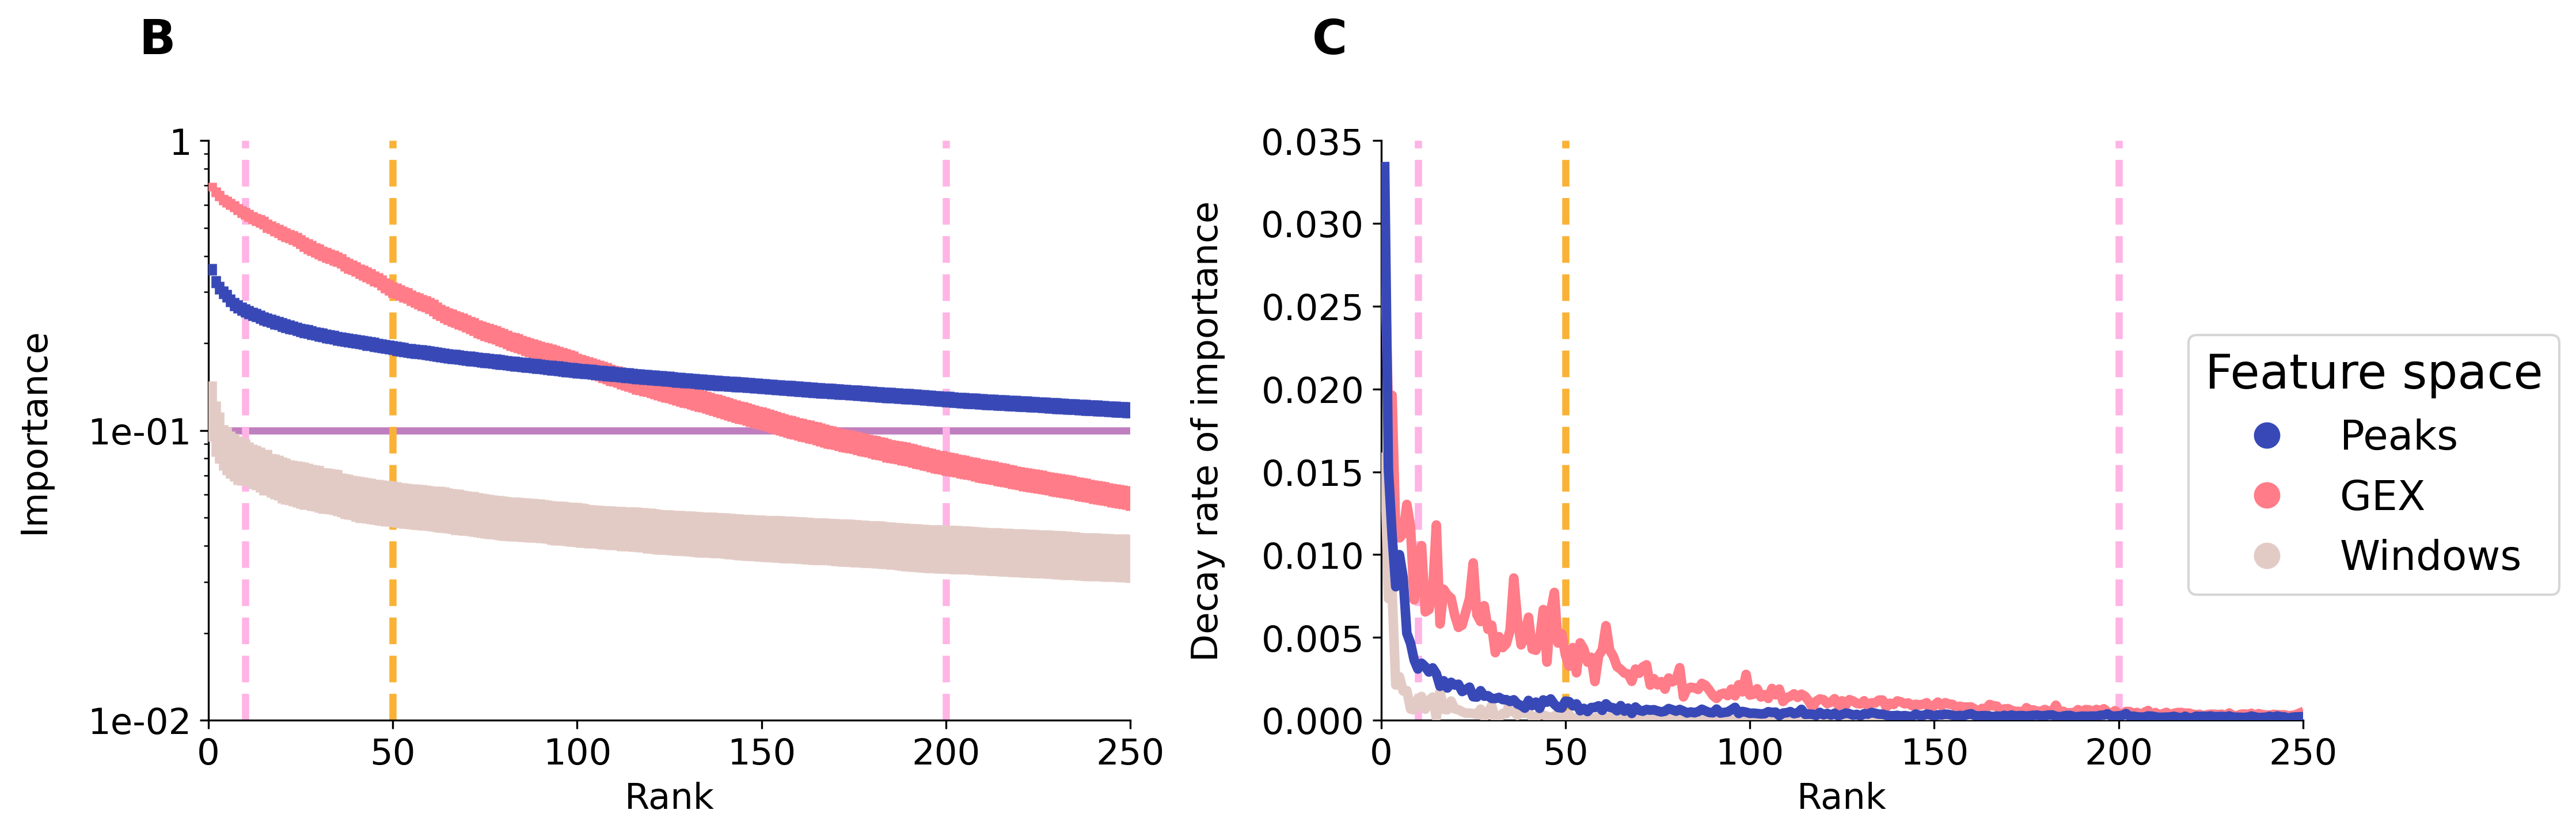

In [4]:
params = {'axes.labelsize': 15,
         'axes.titlesize': 15,
         'xtick.labelsize' : 15,
         'ytick.labelsize': 15,
         "lines.linewidth" : 4,
         "figure.dpi" : 300,
         "figure.figsize": [15, 5]}
plt.rcParams.update(params) 
fs_order=["Peaks","GEX","Windows"]
feats_palette = {fs_order[i] : ut.colors_to_use_bright[9:12][i] for i in range(len(fs_order))}
fig, axs = plt.subplots(1,2)

x=[i+1 for i in range(0, len(distributions["Peak"]))]
y=distributions["Peak"]
axs[0].errorbar(x=x, y=y, yerr=distributions_std["Peak"], color=feats_palette["Peaks"], ls="None", zorder=15, label="Peaks")
x=[i+1 for i in range(0, len(distributions["GEX"]))]
y=distributions["GEX"]
axs[0].errorbar(x=x, y=y, yerr=distributions_std["GEX"], color=feats_palette["GEX"], ls="None", zorder=10, label="GEX")
x=[i+1 for i in range(0, len(distributions["Window"]))]
y=distributions["Window"]
axs[0].errorbar(x=x, y=y, yerr=distributions_std["Window"], color=feats_palette["Windows"], ls="None", zorder=5, label="Windows")
axs[0].set_ylabel("Importance", labelpad=15)
axs[0].set_yscale("log")
axs[0].axhline(y=0.1, xmin=0, xmax=250, color="purple", alpha=0.5, linestyle="-", ms=1, zorder=1, linewidth = 3)


x=[i+1 for i in range(0, len(distributions["Peak"])-1)]
y=[distributions["Peak"][1+i]-distributions["Peak"][i] for i in range(0, len(distributions["Peak"])-1)]
axs[1].plot(x, -1*np.array(y), color=feats_palette["Peaks"], zorder=15, label="Peaks")

x=[i+1 for i in range(0, len(distributions["GEX"])-1)]
y=[distributions["GEX"][1+i]-distributions["GEX"][i] for i in range(0, len(distributions["GEX"])-1)]
axs[1].plot(x, -1*np.array(y), color=feats_palette["GEX"], zorder=10, label="GEX")

x=[i+1 for i in range(0, len(distributions["Window"])-1)]
y=[distributions["Window"][1+i]-distributions["Window"][i] for i in range(0, len(distributions["Window"])-1)]
axs[1].plot(x, -1*np.array(y), color=feats_palette["Windows"], zorder=5, label="Windows")
#ax.scatter(x=x, y=y, s=5, color="black", marker="o", zorder=10)
axs[1].set_ylabel("Decay rate of importance", labelpad=15)
axs[1].set_ylim([0, 0.035])

for i, ax in enumerate(axs):
    ax.set_xlabel("Rank")
    ax.set_xlim([0,250])
 #   ax.set_xscale("log")
    ax.axvline(x=10, ymin=0, ymax=1, color=ut.colors_to_use_pastel[3], linestyle="--", zorder=1, linewidth = 3)
    ax.axvline(x=50, ymin=0, ymax=1, color=ut.colors_to_use_bright[-6], linestyle="--", zorder=1, linewidth = 3)
    ax.axvline(x=200, ymin=0, ymax=1, color=ut.colors_to_use_pastel[3], linestyle="--", zorder=1, linewidth = 3)
    ax.text(-0.075, 1.15, string.ascii_uppercase[i+1], transform=ax.transAxes, size=20, weight='bold',rotation=0)  
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

handles=[]
for key in feats_palette.keys():
    handles.append(mlines.Line2D([], [], color=feats_palette[key], marker='o', linestyle='None', markersize=10, label=key))
axs[1].legend(handles=handles, bbox_to_anchor=(1.3, 0.7), title="Feature space", fontsize=17, title_fontsize=20)
axs[0].set_yticks(np.logspace(-2, 0, 3), ['{:.0e}'.format(i) for i in np.logspace(-2, 0, 3)[:-1]]+[1])

fig.tight_layout(h_pad=2)
plt.savefig("Figures/SEAGALL_Fig5_Up.png", format="png", dpi=300, bbox_inches='tight')
plt.show()

In [5]:
perf=pd.read_csv("Tables/F1PrecRec.tsv.gz", sep="\t", index_col=0)
stabspec=pd.read_csv("Tables/StabSpec.tsv.gz", sep="\t", index_col=0)
xaiother=pd.read_csv("Tables/SEAGALL_Scanpy_SnapATAC2_Inter_T.tsv.gz", sep="\t", index_col=0)
xaiother_50=xaiother[xaiother["Threshold"]==50].copy()
covexpr=pd.read_csv("Tables/SEAGALL_Scanpy_SnapATAC2_Coverage_Expression.tsv.gz", sep="\t", index_col=0)
stn=pd.read_csv("Tables/SEAGALL_Scanpy_SnapATAC2_STN.tsv.gz", sep="\t", index_col=0)

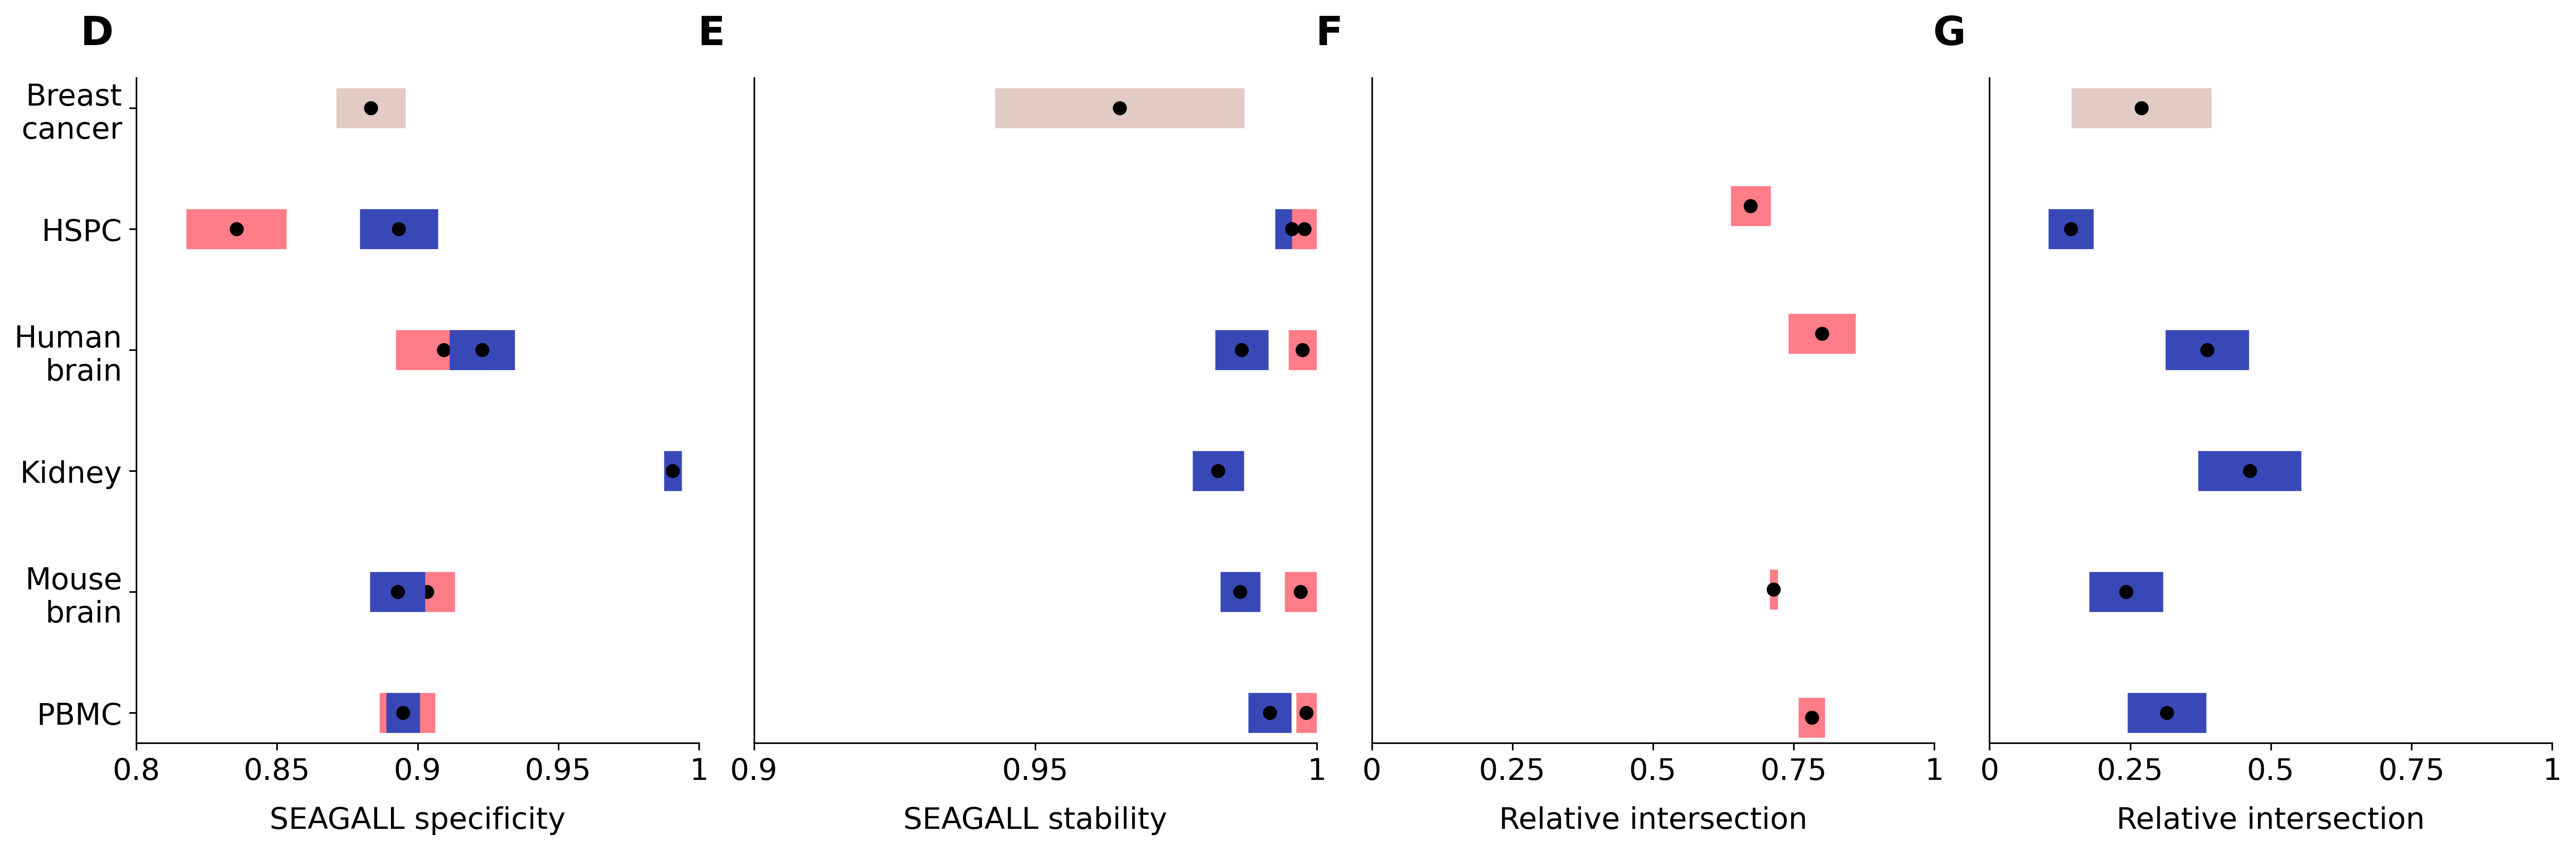

In [6]:
params = {'axes.labelsize': 15,
         'axes.titlesize': 15,
         'xtick.labelsize' : 15,
         'ytick.labelsize': 15,
         "lines.linewidth" : 4,
         "figure.dpi" : 300,
         "figure.figsize": [18, 6]}
plt.rcParams.update(params) 

fs_order = ["Peaks", "GEX", "Windows"]
feats_palette = {fs_order[i]: ut.colors_to_use_bright[9:12][i] for i in range(len(fs_order))}

# --- Global tissue order (with line breaks) ---
name_order = [
    "Breast\ncancer",
    "HSPC",
    "Human\nbrain",
    "Kidney",
    "Mouse\nbrain",
    "PBMC",
][::-1]
name_to_y = {name: i for i, name in enumerate(name_order)}

fig, axs = plt.subplots(1, 4)
axs = axs.flatten()

def normalise_names(df):
    df = df.copy()
    df["Name"] = df["Name"].str.replace("Breast cancer", "Breast\ncancer")
    df["Name"] = df["Name"].str.replace("Human brain", "Human\nbrain")
    df["Name"] = df["Name"].str.replace("Mouse brain", "Mouse\nbrain")
    return df

def plot_errorbars(ax, df, fs, value_col, feats_palette, zorder=1):
    """Plot means ± sem on fixed y-order, skipping missing tissues."""
    d = df[df["FeaturesSpace"] == fs]
    if d.empty:
        return
    d = normalise_names(d)

    stats = d.groupby("Name")[value_col].agg(["mean", "sem"])

    y_idx, means, sems = [], [], []
    for name in name_order:
        if name in stats.index:
            y_idx.append(name_to_y[name])
            means.append(stats.loc[name, "mean"])
            sems.append(stats.loc[name, "sem"])

    if not y_idx:
        return

    ax.errorbar(
        x=np.array(means),
        y=np.array(y_idx),
        xerr=np.array(sems),
        ls='none',
        ecolor=feats_palette[fs],
        elinewidth=20,
        marker="o",
        c="black",
        label=fs,
        zorder=zorder,
    )

for fs in fs_order:
    zorder = 10 if fs == "Peaks" else 1

    # XAIF specificity
    plot_errorbars(axs[0], stabspec, fs, "Specificity", feats_palette, zorder=zorder)

    # XAIF stability
    plot_errorbars(axs[1], stabspec, fs, "Stability", feats_palette)

    # Normalised intersection with Scanpy
    if fs == "GEX":
        plot_errorbars(axs[2], xaiother_50[xaiother_50["FeaturesSpace"]=="GEX"], fs, "Similarity", feats_palette)

    # Normalised intersection with SnapATAC2
    elif fs in ["Peaks", "Windows"]:
        plot_errorbars(axs[3], xaiother_50[xaiother_50["FeaturesSpace"]==fs], fs, "Similarity", feats_palette)

# --- Set the same y-axis coordinates for all axes ---
for ax in axs:
    ax.set_yticks(range(len(name_order)))
    ax.set_yticklabels(name_order)

# Hide y-ticks where you don’t want to show them
axs[1].set_yticks([])      # keep axis scale but hide ticks
axs[2].set_yticks([])      # keep axis scale but hide ticks
axs[3].set_yticks([])      # keep axis scale but hide ticks
axs[1].set_ylabel("")
axs[2].set_ylabel("")
axs[0].set_ylabel("")
axs[0].yaxis.set_label_coords(-0.6, y=0.5)

axs[0].set_xlabel("SEAGALL specificity", labelpad=10)
axs[1].set_xlabel("SEAGALL stability", labelpad=10)
axs[2].set_xlabel("Relative intersection", labelpad=10)
axs[3].set_xlabel("Relative intersection", labelpad=10)

for i in range(0, 4):
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
    axs[i].text(-0.1, 1.05, string.ascii_uppercase[i+3],transform=axs[i].transAxes, size=20, weight='bold', rotation=0)

axs[0].set_xlim([0.8, 1])
xticks = [0.8, 0.85, 0.9, 0.95, 1]
axs[0].set_xticks(xticks, xticks)

axs[1].set_xlim([0.9, 1])
xticks = [0.9, 0.95, 1]
axs[1].set_xticks(xticks, xticks)

axs[2].set_xlim([0, 1])
xticks = [0, 0.25, 0.5, 0.75, 1]
axs[2].set_xticks(xticks, xticks)

axs[3].set_xlim([0, 1])
xticks = [0, 0.25, 0.5, 0.75, 1]
axs[3].set_xticks(xticks, xticks)

fig.tight_layout(w_pad=0.1)
plt.savefig("Figures/SEAGALL_Fig5_Middle.png", format="png", dpi=300, bbox_inches='tight')
plt.show()

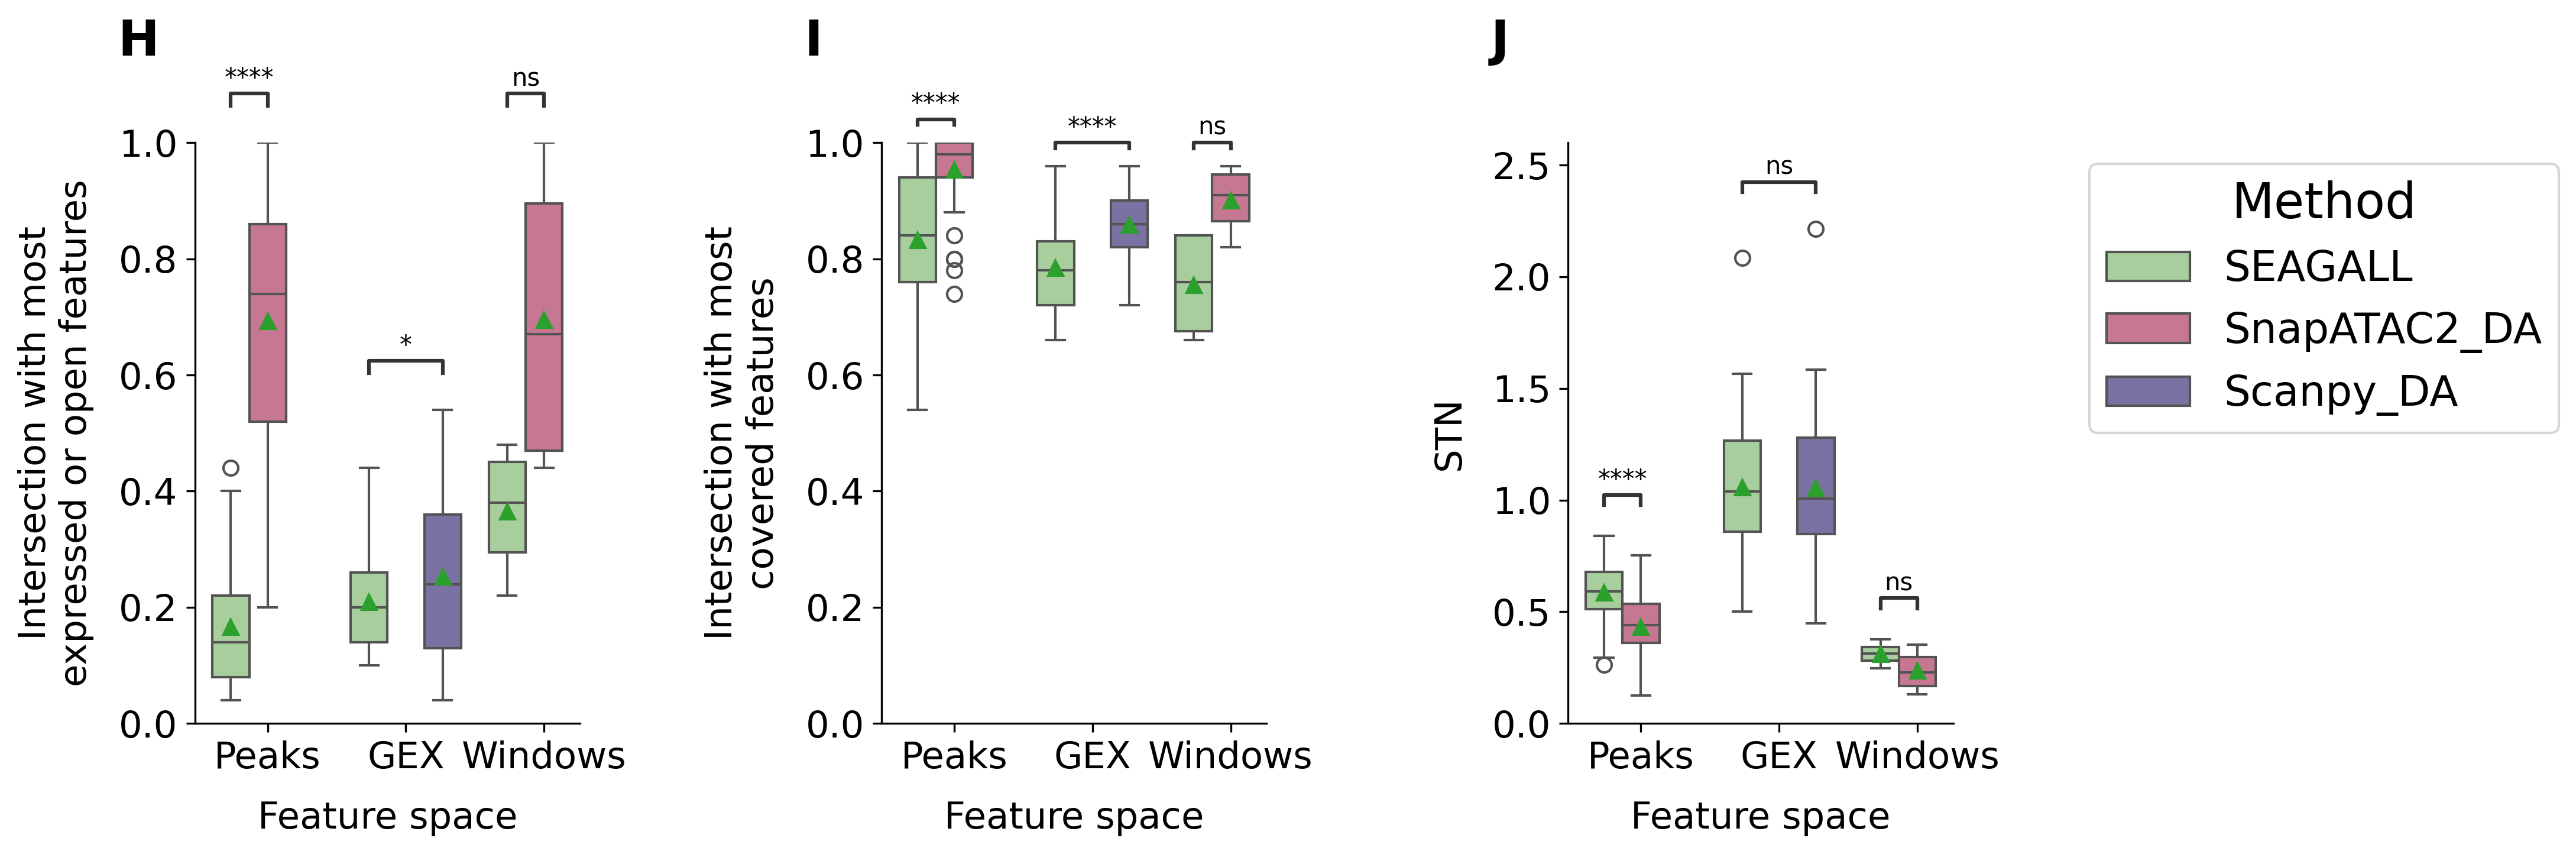

In [7]:
params = {'axes.labelsize': 15,
         'axes.titlesize': 15,
         'xtick.labelsize' : 15,
         'ytick.labelsize': 15,
         "lines.linewidth" : 4,
         "figure.dpi" : 300,
         "figure.figsize": [15, 5]}
plt.rcParams.update(params) 
fig, axs = plt.subplots(1,3)
axs=axs.flatten()
from itertools import combinations

def build_pairs(df, x_col="FeaturesSpace", hue_col="Method",
                banned_method_pairs=[("Scanpy_DA", "SnapATAC2_DA")]):
    """
    Build all pairwise comparisons for each level of x_col,
    but skip any method pairs listed in banned_method_pairs.
    """
    if banned_method_pairs is None:
        banned_method_pairs = []
    # store as frozensets so order doesn't matter
    banned = {frozenset(p) for p in banned_method_pairs}

    # all actually present combinations
    present = set(zip(df[x_col], df[hue_col]))
    
    x_levels = df[x_col].unique()
    hue_levels = df[hue_col].unique()
    
    pairs = []
    for x in x_levels:
        methods_here = [m for m in hue_levels if (x, m) in present]
        for m1, m2 in combinations(methods_here, 2):
            # skip DA vs SnapATAC2, etc.
            if frozenset((m1, m2)) in banned:
                continue
            pairs.append(((x, m1), (x, m2)))
    return pairs

fig_args = {'y': "Intersection", 'x': "FeaturesSpace", "hue" : "Method", 'data': covexpr[covexpr["Bias"]=="Expression"],
            'dodge': True, "palette" : ut.selected_colors[::-1], "showfliers" : True}
configuration = {'test':'Wilcoxon', 'text_format':'star'}
sns.boxplot(ax=axs[0], **fig_args, showmeans=True)
annotator = Annotator(ax=axs[0], orient="v", pairs=build_pairs(fig_args['data']), plot='boxplot', verbose=False, **fig_args)
annotator.configure(**configuration).apply_test().annotate()

fig_args = {'y': "Intersection", 'x': "FeaturesSpace", "hue" : "Method", 'data': covexpr[covexpr["Bias"]=="Coverage"],
            'dodge': True, "palette" : ut.selected_colors[::-1], "showfliers" : True}
configuration = {'test':'Wilcoxon', 'text_format':'star'}
sns.boxplot(ax=axs[1], **fig_args, showmeans=True)
annotator = Annotator(ax=axs[1], orient="v", pairs=build_pairs(fig_args['data']), plot='boxplot', verbose=False, **fig_args)
annotator.configure(**configuration).apply_test().annotate()

fig_args = {'y': "STN", 'x': "FeaturesSpace", "hue" : "Method", 'data': stn,
            'dodge': True, "palette" : ut.selected_colors[::-1],"showfliers" : True}
configuration = {'test':'Wilcoxon', 'text_format':'star'}
sns.boxplot(ax=axs[2], **fig_args, showmeans=True)
annotator = Annotator(ax=axs[2], orient="v", pairs=build_pairs(fig_args['data']), plot='boxplot', verbose=False, **fig_args)
annotator.configure(**configuration).apply_test().annotate()
axs[0].get_legend().remove()
axs[1].get_legend().remove()
axs[2].legend(bbox_to_anchor=(1.3, 1), title="Method", fontsize=17, title_fontsize=20)

for i, ax in enumerate(axs):
    ax.set_xlabel("Feature space", labelpad=10)

axs[0].set_ylabel("Intersection with most\nexpressed or open features", labelpad=10)
axs[1].set_ylabel("Intersection with most\ncovered features", labelpad=10)
axs[2].set_ylabel("STN", labelpad=10)

for i in range(0,3):
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)   
    axs[i].text(-0.2, 1.15, string.ascii_uppercase[i+7], transform=axs[i].transAxes, size=20, weight='bold',rotation=0)    
axs[0].set_ylim([0,1])
axs[1].set_ylim([0,1])
axs[2].set_ylim([0,2.6])
fig.tight_layout(w_pad=4)
plt.savefig("Figures/SEAGALL_Fig5_Down.png", format="png", dpi=300, bbox_inches='tight')
plt.show()

## SEAGALL_Fig6

In [8]:
atac=sc.read_h5ad("Datasets/10XhsBrain3kMO/FeatureSpaces/Peak/CM/10XhsBrain3kMO_Peak_Raw.h5ad")
atac.layers["counts"]=atac.X.copy()
defatac=sc.read_h5ad("Datasets/10XhsBrain3kMO/FeatureSpaces/Peak/CM/10XhsBrain3kMO_Peak_Def.h5ad")
sc.pp.normalize_total(atac)
atac=atac[defatac.obs.index]
atac.obs=defatac.obs
atac.uns=defatac.uns
atac.obsm=defatac.obsm
atac.obsp=defatac.obsp
atac

AnnData object with n_obs × n_vars = 2726 × 174200
    obs: 'CellType', 'Raw_celltype', 'nucleosome_signal', 'tss_enrichment_score', 'n_features', 'log_n_features', 'n_counts', 'log_n_counts', 'passes_filter', 'leiden', 'target'
    var: 'chr', 'start', 'stop'
    uns: 'fragment_lengths', 'hvg', 'inv_map', 'leiden', 'log1p', 'map', 'neighbors', 'pca', 'tss_enrichment', 'umap'
    obsm: 'X_AE', 'X_GRAE', 'X_GRAE_2D', 'X_pca', 'X_umap'
    layers: 'counts'
    obsp: 'AE_kNN', 'GRAE_kNN', 'GRAE_kNN2D', 'connectivities', 'distances'

In [97]:
os.system("scanMotifGenomeWide.pl Datasets/10XhsBrain3kMO/FeatureSpaces/Peak/XAI/MotifAnalysis/HOMER_XAIonly/Astrocyte_progenitor/knownResults/known3.motif \
../AnnotRef/hs/T2T/chm13v2.0.fa -p 8 > Datasets/10XhsBrain3kMO/FeatureSpaces/Peak/XAI/MotifAnalysis/HOMER_XAIonly/Astrocyte_progenitor/knownResults/SOX9_TFBS.bed")

'\nos.system("scanMotifGenomeWide.pl Datasets/10XhsBrain3kMO/FeatureSpaces/Peak/XAI/MotifAnalysis/HOMER_XAIonly/Astrocyte_progenitor/knownResults/known3.motif ../AnnotRef/hs/T2T/chm13v2.0.fa -p 8 > Datasets/10XhsBrain3kMO/FeatureSpaces/Peak/XAI/MotifAnalysis/HOMER_XAIonly/Astrocyte_progenitor/knownResults/SOX9_TFBS.bed")\n'

In [9]:
df=pd.read_csv("Datasets/10XhsBrain3kMO/FeatureSpaces/Peak/XAI/MotifAnalysis/HOMER_XAIonly/Astrocyte_progenitor/knownResults/SOX9_TFBS.bed", sep="\t", header=None)
df.head()

0     1     2     3  4  \
0  Sox9(HMG)/Limb-SOX9-ChIP-Seq(GSE73225)/Homer-1  chr1  4195  4206  +   
1  Sox9(HMG)/Limb-SOX9-ChIP-Seq(GSE73225)/Homer-2  chr1  5336  5347  +   
2  Sox9(HMG)/Limb-SOX9-ChIP-Seq(GSE73225)/Homer-3  chr1  5393  5404  -   
3  Sox9(HMG)/Limb-SOX9-ChIP-Seq(GSE73225)/Homer-4  chr1  8061  8072  -   
4  Sox9(HMG)/Limb-SOX9-ChIP-Seq(GSE73225)/Homer-5  chr1  8230  8241  -   

          5             6  
0  7.488729  AGAGCTTATTGT  
1  7.878912  ATGTCCCTTTGT  
2  7.438264  ACAAAGGAAGTT  
3  8.258115  ACAATGCTTTCT  
4  7.548654  ACAAAGAATTAT

In [100]:
df[[1,2,3]].to_csv("Datasets/10XhsBrain3kMO/FragFile/SOX9_TFBSAll.bed", sep="\t", header=None, index=None)
print("zcat Datasets/10XhsBrain3kMO/FragFile/atac_fragments.tsv.gz |\
bedtools intersect -a stdin -b Datasets/10XhsBrain3kMO/FragFile/SOX9_TFBS.bed \
> Datasets/10XhsBrain3kMO/FragFile/SOX9_TFBSAll_Openness.tsv")

'\ndf[[1,2,3]].to_csv("Datasets/10XhsBrain3kMO/FragFile/SOX9_TFBSAll.bed", sep="\t", header=None, index=None)\nprint("zcat Datasets/10XhsBrain3kMO/FragFile/atac_fragments.tsv.gz |bedtools intersect -a stdin -b Datasets/10XhsBrain3kMO/FragFile/SOX9_TFBS.bed > Datasets/10XhsBrain3kMO/FragFile/SOX9_TFBSAll_Openness.tsv")\n'

In [10]:
TFBS=pd.read_csv("Datasets/10XhsBrain3kMO/FragFile/SOX9_TFBSAll_Openness.tsv", sep="\t", header=None, index_col=3)
TFBS["cell"]=TFBS.index
TFBS=pd.DataFrame(TFBS.groupby("cell")[4].sum())
TFBS.rename({4 : "TFBS openness"}, axis=1, inplace=True)
print(TFBS.shape)
TFBS.head()

(230059, 1)


TFBS openness
cell                             
AAACAGCCAAACCTTG-1              3
AAACAGCCAAAGCGCA-1              1
AAACAGCCAAAGCTAA-1              1
AAACAGCCAAAGCTCC-1              1
AAACAGCCAAAGGCCA-1              1

In [11]:
TFBS=TFBS.loc[ut.intersection([atac.obs.index, TFBS.index])]
atac=atac[TFBS.index]
atac.obs["counts"]=atac.layers["counts"].sum(axis=1)
atac.obs["SOX9_TFBS"]=0
atac.obs.loc[TFBS.index, "SOX9_TFBS"]=TFBS["TFBS openness"]/atac[TFBS.index].obs["counts"]
atac

AnnData object with n_obs × n_vars = 2726 × 174200
    obs: 'CellType', 'Raw_celltype', 'nucleosome_signal', 'tss_enrichment_score', 'n_features', 'log_n_features', 'n_counts', 'log_n_counts', 'passes_filter', 'leiden', 'target', 'counts', 'SOX9_TFBS'
    var: 'chr', 'start', 'stop'
    uns: 'fragment_lengths', 'hvg', 'inv_map', 'leiden', 'log1p', 'map', 'neighbors', 'pca', 'tss_enrichment', 'umap'
    obsm: 'X_AE', 'X_GRAE', 'X_GRAE_2D', 'X_pca', 'X_umap'
    layers: 'counts'
    obsp: 'AE_kNN', 'GRAE_kNN', 'GRAE_kNN2D', 'connectivities', 'distances'

In [12]:
gex=sc.read_h5ad("Datasets/10XhsBrain3kMO/FeatureSpaces/GEX/CM/10XhsBrain3kMO_GEX_Raw.h5ad")
gex.layers["counts"]=gex.X.copy()
defgex=sc.read_h5ad("Datasets/10XhsBrain3kMO/FeatureSpaces/GEX/CM/10XhsBrain3kMO_GEX_Def.h5ad")
sc.pp.normalize_total(gex)
sc.pp.log1p(gex)
gex=gex[defgex.obs.index]
gex.obs=defgex.obs
gex.uns=defgex.uns
gex.obsm=defgex.obsm
gex.obsp=defgex.obsp
gex

AnnData object with n_obs × n_vars = 2441 × 43925
    obs: 'CellType', 'Raw_celltype', 'n_features', 'log_n_features', 'n_counts', 'log_n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_MT', 'pct_counts_MT', 'doublet_score', 'predicted_doublet', 'passes_filter', 'leiden', 'target'
    var: 'gene_ids', 'feature_types'
    uns: 'hvg', 'inv_map', 'leiden', 'log1p', 'map', 'neighbors', 'pca', 'scrublet', 'umap'
    obsm: 'X_AE', 'X_GRAE', 'X_GRAE_2D', 'X_pca', 'X_umap'
    layers: 'counts'
    obsp: 'AE_kNN', 'GRAE_kNN', 'GRAE_kNN2D', 'connectivities', 'distances'

In [13]:
inter=ut.intersection([atac.obs.index, gex.obs.index])
atac=atac[inter]
gex=gex[inter]
gex.obs["X_GRAE_GEX"]=gex.obsm["X_GRAE_2D"].T[0]*-1
gex.obs["Y_GRAE_GEX"]=gex.obsm["X_GRAE_2D"].T[1]
atac.obs["X_GRAE_GEX"]=gex.obsm["X_GRAE_2D"].T[0]*-1
atac.obs["Y_GRAE_GEX"]=gex.obsm["X_GRAE_2D"].T[1]

gex.obs["X_GRAE_ATAC"]=atac.obsm["X_GRAE_2D"].T[0]*-1
gex.obs["Y_GRAE_ATAC"]=atac.obsm["X_GRAE_2D"].T[1]
atac.obs["X_GRAE_ATAC"]=atac.obsm["X_GRAE_2D"].T[0]*-1
atac.obs["Y_GRAE_ATAC"]=atac.obsm["X_GRAE_2D"].T[1]

astroprog=gex[gex.obs["CellType"]=="Astrocyte_progenitor"].obs.index
astro=gex[gex.obs["CellType"]=="Astrocyte"].obs.index

astrodata_atac=atac[ut.flat_list([astro, astroprog])].copy()
astrodata_gex=gex[ut.flat_list([astro, astroprog])].copy()
astrodata_gex.obs["CT"]=astrodata_gex.obs.CellType
astrodata_gex.obs["CT"].replace({"Astrocyte": "Astrocytes", "Astrocyte_progenitor" : "Astrocytes\nprogenitors"}, inplace=True)

gex.obsm["X_umap"]=np.array([atac.obsm["X_GRAE_2D"].T[0]*-1, atac.obsm["X_GRAE_2D"].T[1]]).T

In [14]:
interall=ut.intersection([astrodata_gex.obs.index, atac.obs.index])
astrodata_gex.obs["SOX9_TFBS"]=0
astrodata_gex.obs.loc[interall, "SOX9_TFBS"]=atac[interall].obs["SOX9_TFBS"]
astrodata_gex.obsm["X_umap"]=np.array([astrodata_atac.obsm["X_GRAE_2D"].T[0]*-1, astrodata_atac.obsm["X_GRAE_2D"].T[1]]).T

In [15]:
SOX9 = pd.read_csv('Datasets/10XhsBrain3kMO/FeatureSpaces/Peak/XAI/MotifAnalysis/HOMER_XAIonly/Astrocyte_progenitor/knownResults/known3.motif',
                 sep="\t", header=None, names=["A","C","G","T"], skiprows=1)

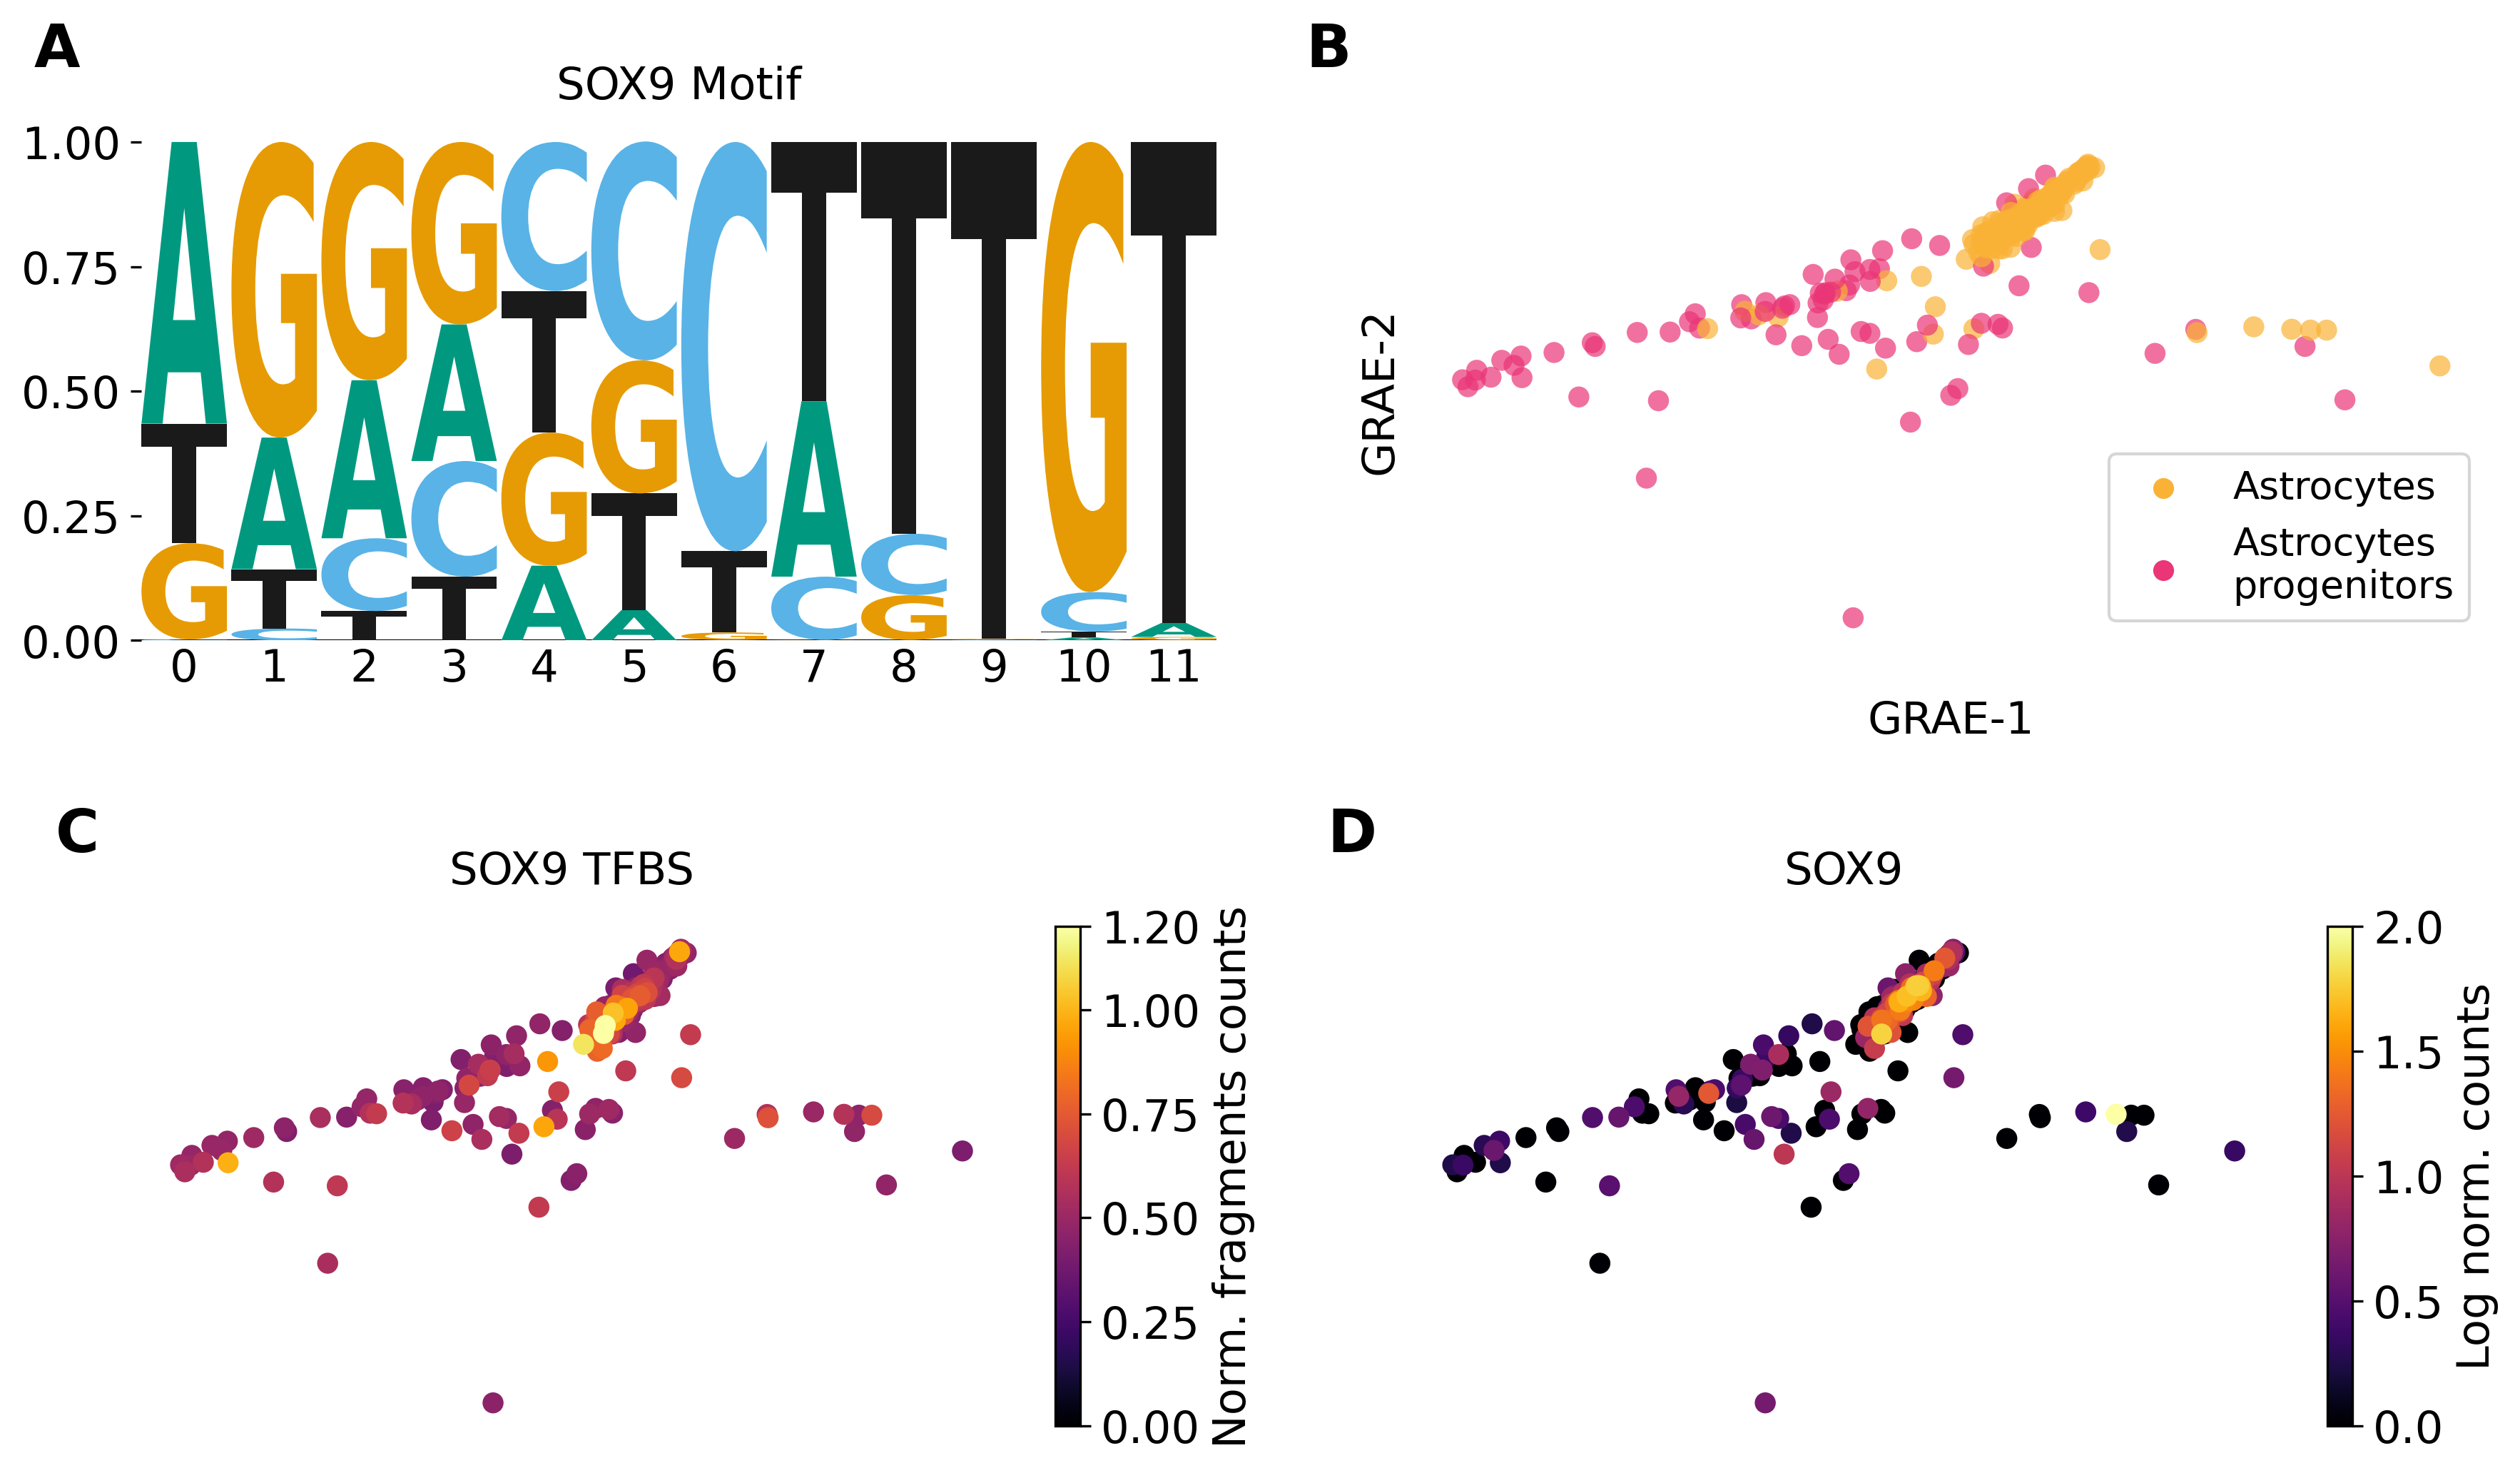

In [16]:
params = {'axes.labelsize': 15,
         'axes.titlesize': 15,
         'xtick.labelsize' : 15,
         'ytick.labelsize': 15,
         "lines.linewidth" : 4,
         "figure.dpi" : 300,
         "figure.figsize": [12, 7]}
plt.rcParams.update(params) 
fig, axs = plt.subplots(2,2)
axs=axs.flatten()

cts_colors={"Astrocytes" : ut.colors_to_use_bright[-6], "Astrocytes\nprogenitors" : ut.colors_to_use_bright[-4]}

cmap=mpl.cm.inferno
sc.pl.umap(astrodata_gex, color="CT", ax=axs[1], frameon=True, show=False, palette=cts_colors, legend_fontsize=13, size=200,
          legend_loc="lower right", alpha=0.7)
ax=sc.pl.umap(astrodata_gex, color="SOX9_TFBS", ax=axs[2], frameon=False, show=False, legend_fontsize=10, size=200, vmin=0, vmax=1.2, color_map=cmap, colorbar_loc=None)
sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_clim(vmin=0, vmax=1.2)
fig.colorbar(ax=ax, mappable=sm, label="Norm. fragments counts", ticks=[0, 0.25, 0.5, 0.75, 1, 1.2])

ax=sc.pl.umap(astrodata_gex, color="SOX9", ax=axs[3], frameon=False, show=False, vmin=0, vmax=2, legend_fontsize=10, size=200, color_map=cmap, colorbar_loc=None)
sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_clim(vmin=0, vmax=2)
fig.colorbar(ax=ax, mappable=sm, label="Log norm. counts", ticks=[0, 0.5, 1, 1.5, 2])


axs[1].set_title("", y=1.1)
axs[2].set_title("SOX9 TFBS", y=1.05)
axs[3].set_title("SOX9", y=1.05)

for i in range(1,4):
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
    axs[i].spines['left'].set_visible(False)
    axs[i].spines['bottom'].set_visible(False)
    if i < 2:
        axs[i].set_xlabel("GRAE-1", labelpad=20)
        axs[i].set_ylabel("GRAE-2")
    axs[i].text(-0.1, 1.15, string.ascii_uppercase[i], transform=axs[i].transAxes, size=20, weight='bold',rotation=0)  

crp_logo1 = logomaker.Logo(SOX9, shade_below=.5,fade_below=.5, ax=axs[0], color_scheme="colorblind_safe")
crp_logo1.style_spines(visible=False)
crp_logo1.style_xticks(fmt='%d', anchor=0)
crp_logo1.ax.xaxis.set_ticks_position('none')
crp_logo1.ax.xaxis.set_tick_params(pad=-1)
axs[0].set_title("SOX9 Motif", y=1.05)
axs[0].text(-0.1, 1.15, string.ascii_uppercase[0], transform=axs[0].transAxes, size=20, weight='bold',rotation=0)  

fig.tight_layout(w_pad=2, h_pad=2)
plt.savefig("Figures/SEAGALL_Fig6_Up.png", format="png", dpi=300, bbox_inches='tight')
plt.show()

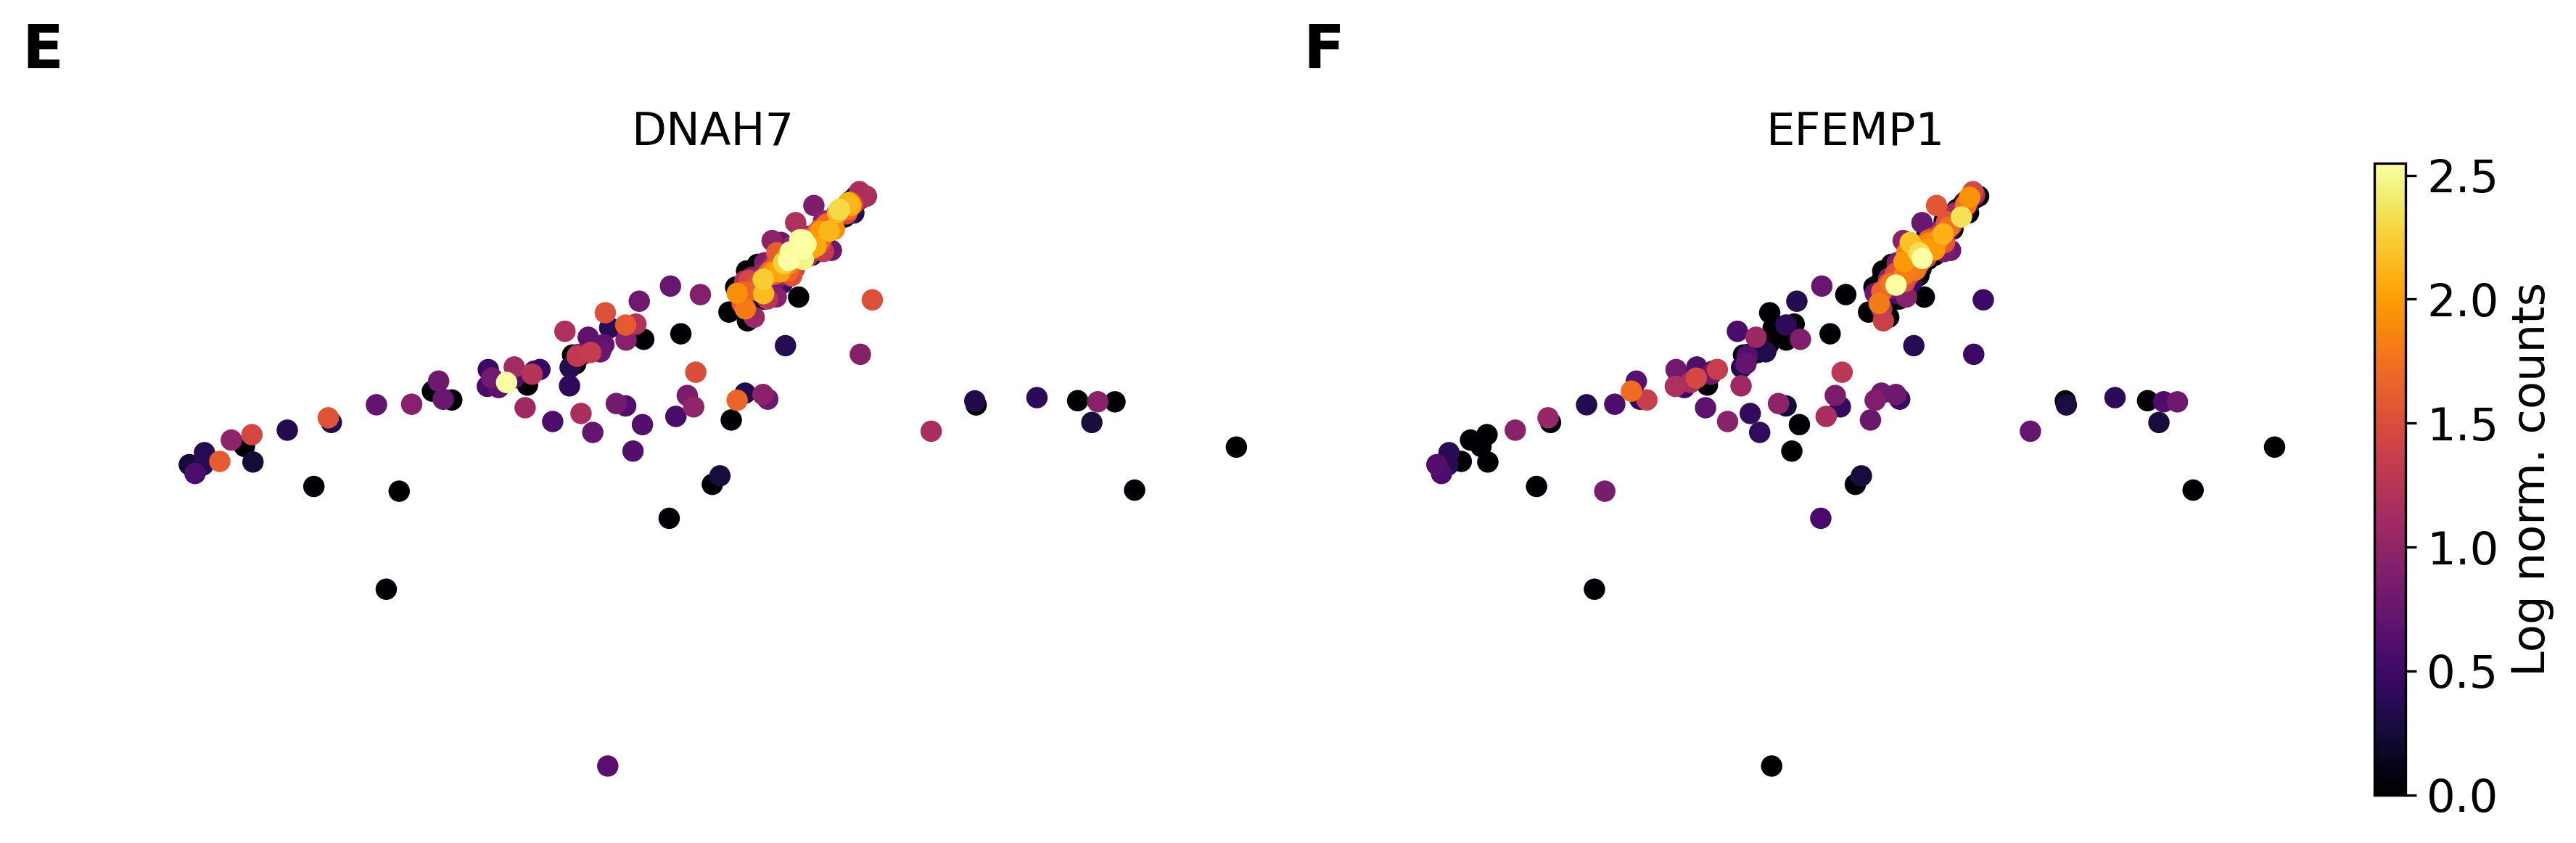

In [17]:
params = {'axes.labelsize': 15,
         'axes.titlesize': 15,
         'xtick.labelsize' : 15,
         'ytick.labelsize': 15,
         "lines.linewidth" : 4,
         "figure.dpi" : 300,
         "figure.figsize": [12, 4]}
plt.rcParams.update(params) 
fig, axs = plt.subplots(1,2)
axs=axs.flatten()

cmap=mpl.cm.inferno

sc.pl.umap(astrodata_gex, color="DNAH7", ax=axs[0], frameon=False, show=False, legend_fontsize=10, size=200, vmin=0, vmax=2.55, color_map=cmap, colorbar_loc=None)
ax=sc.pl.umap(astrodata_gex, color="EFEMP1", ax=axs[1], frameon=False, show=False, vmin=0, vmax=2.55, size=200, color_map=cmap, colorbar_loc=None)
sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_clim(vmin=0, vmax=2.55)
fig.colorbar(ax=ax, mappable=sm, label="Log norm. counts", ticks=[0, 0.5, 1, 1.5, 2, 2.5])
for i in range(0,2):
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
    axs[i].spines['left'].set_visible(False)
    axs[i].spines['bottom'].set_visible(False)
    axs[i].text(-0.1, 1.15, string.ascii_uppercase[i+4], transform=axs[i].transAxes, size=20, weight='bold',rotation=0)  

fig.tight_layout()
plt.savefig("Figures/SEAGALL_Fig6_Down.png", format="png", dpi=300, bbox_inches='tight')
plt.show()

## SEAGALL_SuppFig7

In [18]:
fss = {"GEX" : [], "Peak" : [], "Window" : []}
xaiother=pd.DataFrame(columns=["Dataset","FeaturesSpace", "CT", "Difference","Name","Threshold"])
for dataset, featurespace, label, name in zip(ds_infos["DSs"], ds_infos["FsSs"], ds_infos["LBs"], ds_infos["Names"]):
    xai_file=f"Datasets/{dataset}/FeatureSpaces/{featurespace}/XAI/{dataset}_{featurespace}_GRAE_kNN_{label}_HPO_XAIFeaturesImportance.tsv.gz"
    xai=pd.read_csv(xai_file, sep="\t", index_col=0)
    for col in xai.columns:
        fss[featurespace].append(np.array(xai[col]))        
distributions = {key : pd.DataFrame(fss[key]).mean() for key in fss.keys()}
distributions_std = {key : pd.DataFrame(fss[key]).sem() for key in fss.keys()}

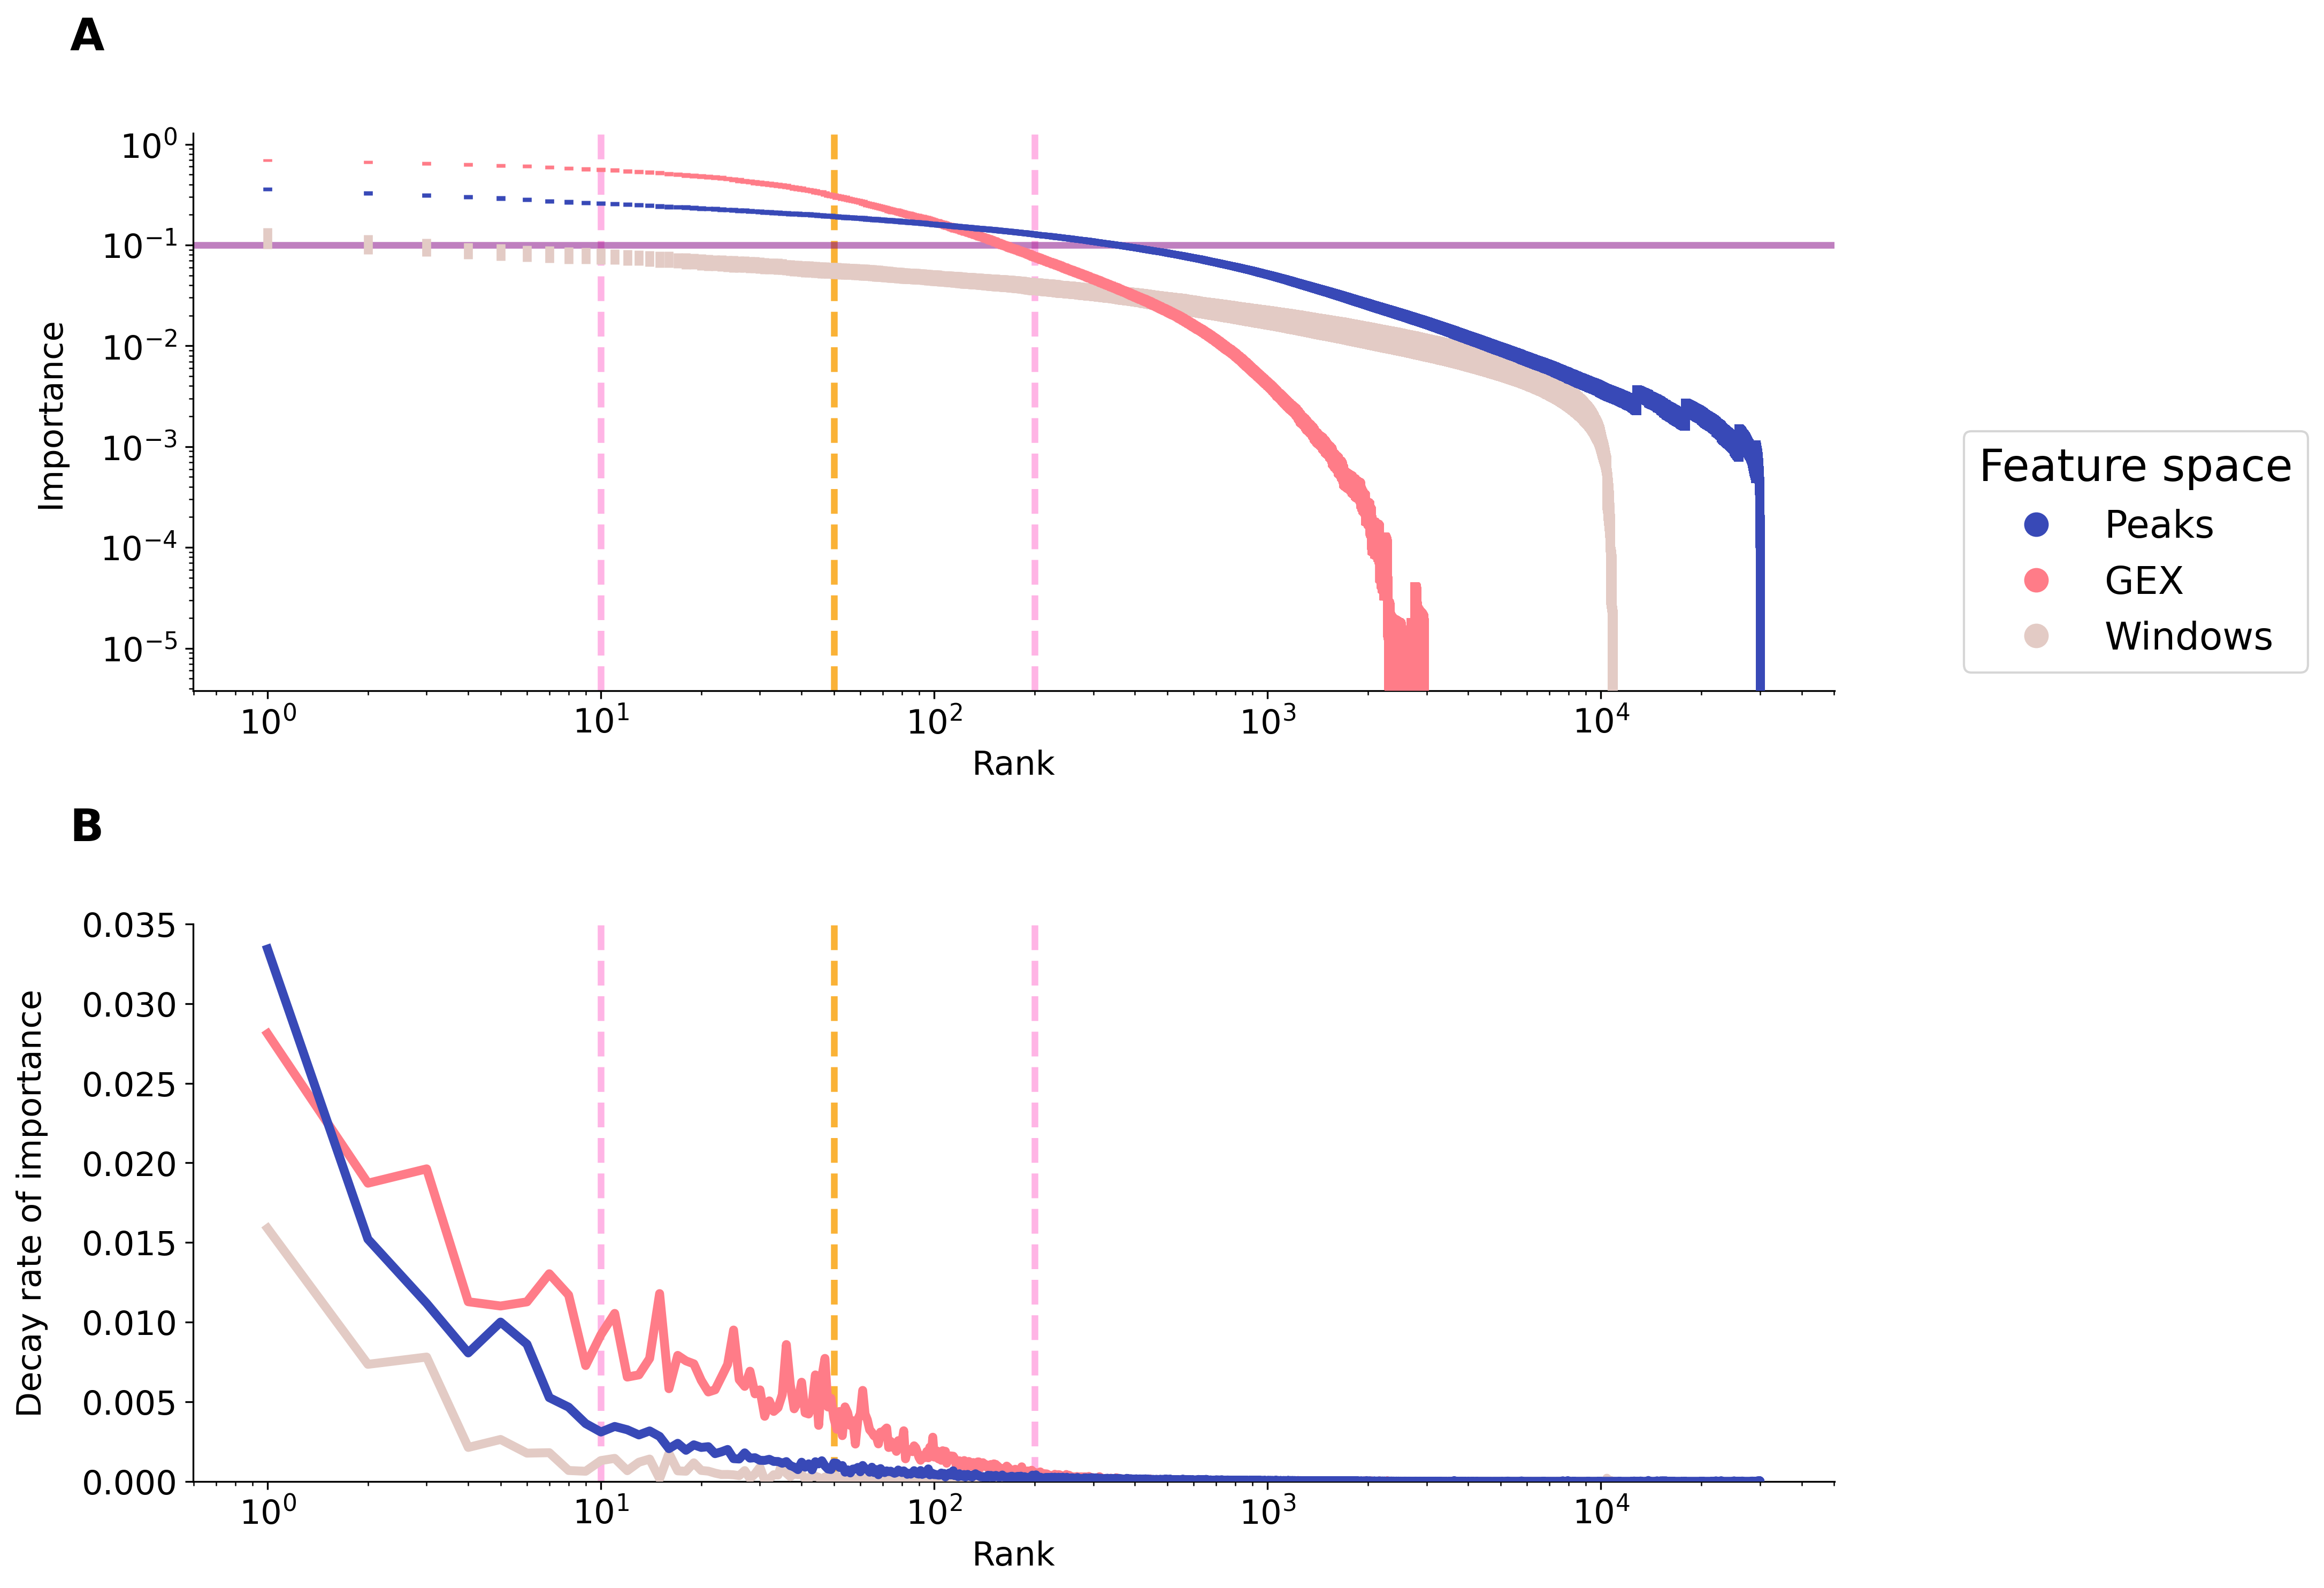

In [19]:
params = {'axes.labelsize': 15,
         'axes.titlesize': 15,
         'xtick.labelsize' : 15,
         'ytick.labelsize': 15,
         "lines.linewidth" : 4,
         "figure.dpi" : 300,
         "figure.figsize": [15, 10]}
plt.rcParams.update(params) 
fs_order=["Peaks","GEX","Windows"]
feats_palette = {fs_order[i] : ut.colors_to_use_bright[9:12][i] for i in range(len(fs_order))}
fig, axs = plt.subplots(2,1)

x=[i+1 for i in range(0, len(distributions["Peak"]))]
y=distributions["Peak"]
axs[0].errorbar(x=x, y=y, yerr=distributions_std["Peak"], color=feats_palette["Peaks"], ls="None", zorder=15, label="Peaks")
#ax.scatter(x=x, y=y, s=5, color="black", marker="o", zorder=10)
x=[i+1 for i in range(0, len(distributions["GEX"]))]
y=distributions["GEX"]
axs[0].errorbar(x=x, y=y, yerr=distributions_std["GEX"], color=feats_palette["GEX"], ls="None", zorder=10, label="GEX")
#ax.scatter(x=x, y=y, s=5, color="black", marker="o", zorder=10)
x=[i+1 for i in range(0, len(distributions["Window"]))]
y=distributions["Window"]
axs[0].errorbar(x=x, y=y, yerr=distributions_std["Window"], color=feats_palette["Windows"], ls="None", zorder=5, label="Windows")
#ax.scatter(x=x, y=y, s=5, color="black", marker="o", zorder=10)
axs[0].set_ylabel("Importance", labelpad=15)
axs[0].set_yticks(np.logspace(-5, 0, 6), ['{:.0e}'.format(i) for i in np.logspace(-5, 0, 6)[:-1]]+[1])
axs[0].set_yscale("log")


x=[i+1 for i in range(0, len(distributions["Peak"])-1)]
y=[distributions["Peak"][1+i]-distributions["Peak"][i] for i in range(0, len(distributions["Peak"])-1)]
axs[1].plot(x, -1*np.array(y), color=feats_palette["Peaks"], zorder=15, label="Peaks")

x=[i+1 for i in range(0, len(distributions["GEX"])-1)]
y=[distributions["GEX"][1+i]-distributions["GEX"][i] for i in range(0, len(distributions["GEX"])-1)]
axs[1].plot(x, -1*np.array(y), color=feats_palette["GEX"], zorder=10, label="GEX")

x=[i+1 for i in range(0, len(distributions["Window"])-1)]
y=[distributions["Window"][1+i]-distributions["Window"][i] for i in range(0, len(distributions["Window"])-1)]
axs[1].plot(x, -1*np.array(y), color=feats_palette["Windows"], zorder=5, label="Windows")
#ax.scatter(x=x, y=y, s=5, color="black", marker="o", zorder=10)
axs[1].set_ylabel("Decay rate of importance", labelpad=15)
axs[1].set_ylim([0, 0.035])

for i, ax in enumerate(axs):
    ax.set_xlabel("Rank")
    ax.set_xscale("log")
    ax.axvline(x=10, ymin=0, ymax=1, color=ut.colors_to_use_pastel[3], linestyle="--", zorder=1, linewidth = 3)
    ax.axvline(x=50, ymin=0, ymax=1, color=ut.colors_to_use_bright[-6], linestyle="--", zorder=1, linewidth = 3)
    ax.axvline(x=200, ymin=0, ymax=1, color=ut.colors_to_use_pastel[3], linestyle="--", zorder=1, linewidth = 3)
    ax.axhline(y=0.1, xmin=0, xmax=5000, color="purple", alpha=0.5, linestyle="-", ms=1, zorder=1, linewidth = 3)
    ax.text(-0.075, 1.15, string.ascii_uppercase[i], transform=ax.transAxes, size=20, weight='bold',rotation=0)  
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

handles=[]
for key in feats_palette.keys():
    handles.append(mlines.Line2D([], [], color=feats_palette[key], marker='o', linestyle='None', markersize=10, label=key))
axs[0].legend(handles=handles, bbox_to_anchor=(1.3, 0.5), title="Feature space", fontsize=17, title_fontsize=20)
   
fig.tight_layout(w_pad=-5)
plt.savefig("Figures/SEAGALL_SuppFig7.png", format="png", dpi=300, bbox_inches='tight')
plt.show()

## SEAGALL_SuppFig8

In [20]:
tot=pd.read_csv("Tables/StabSpec_Threshold.tsv.gz", index_col=0, sep="\t")
xaiother=pd.read_csv("Tables/SEAGALL_Scanpy_SnapATAC2_Inter_T.tsv.gz", index_col=0, sep="\t")
xaiother_lfc=pd.read_csv("Tables/SEAGALL_Scanpy_SnapATAC2_Inter_T_LFC.tsv.gz", index_col=0, sep="\t")
xaiother["Threshold"]=xaiother["Threshold"].astype(int)
xaiother_lfc["Threshold"]=xaiother_lfc["Threshold"].astype(int)
thres=[10, 25, 50, 75, 100, 125, 150, 200, 250, 300, 350, 500, 750, 1000, 1500, 2000]

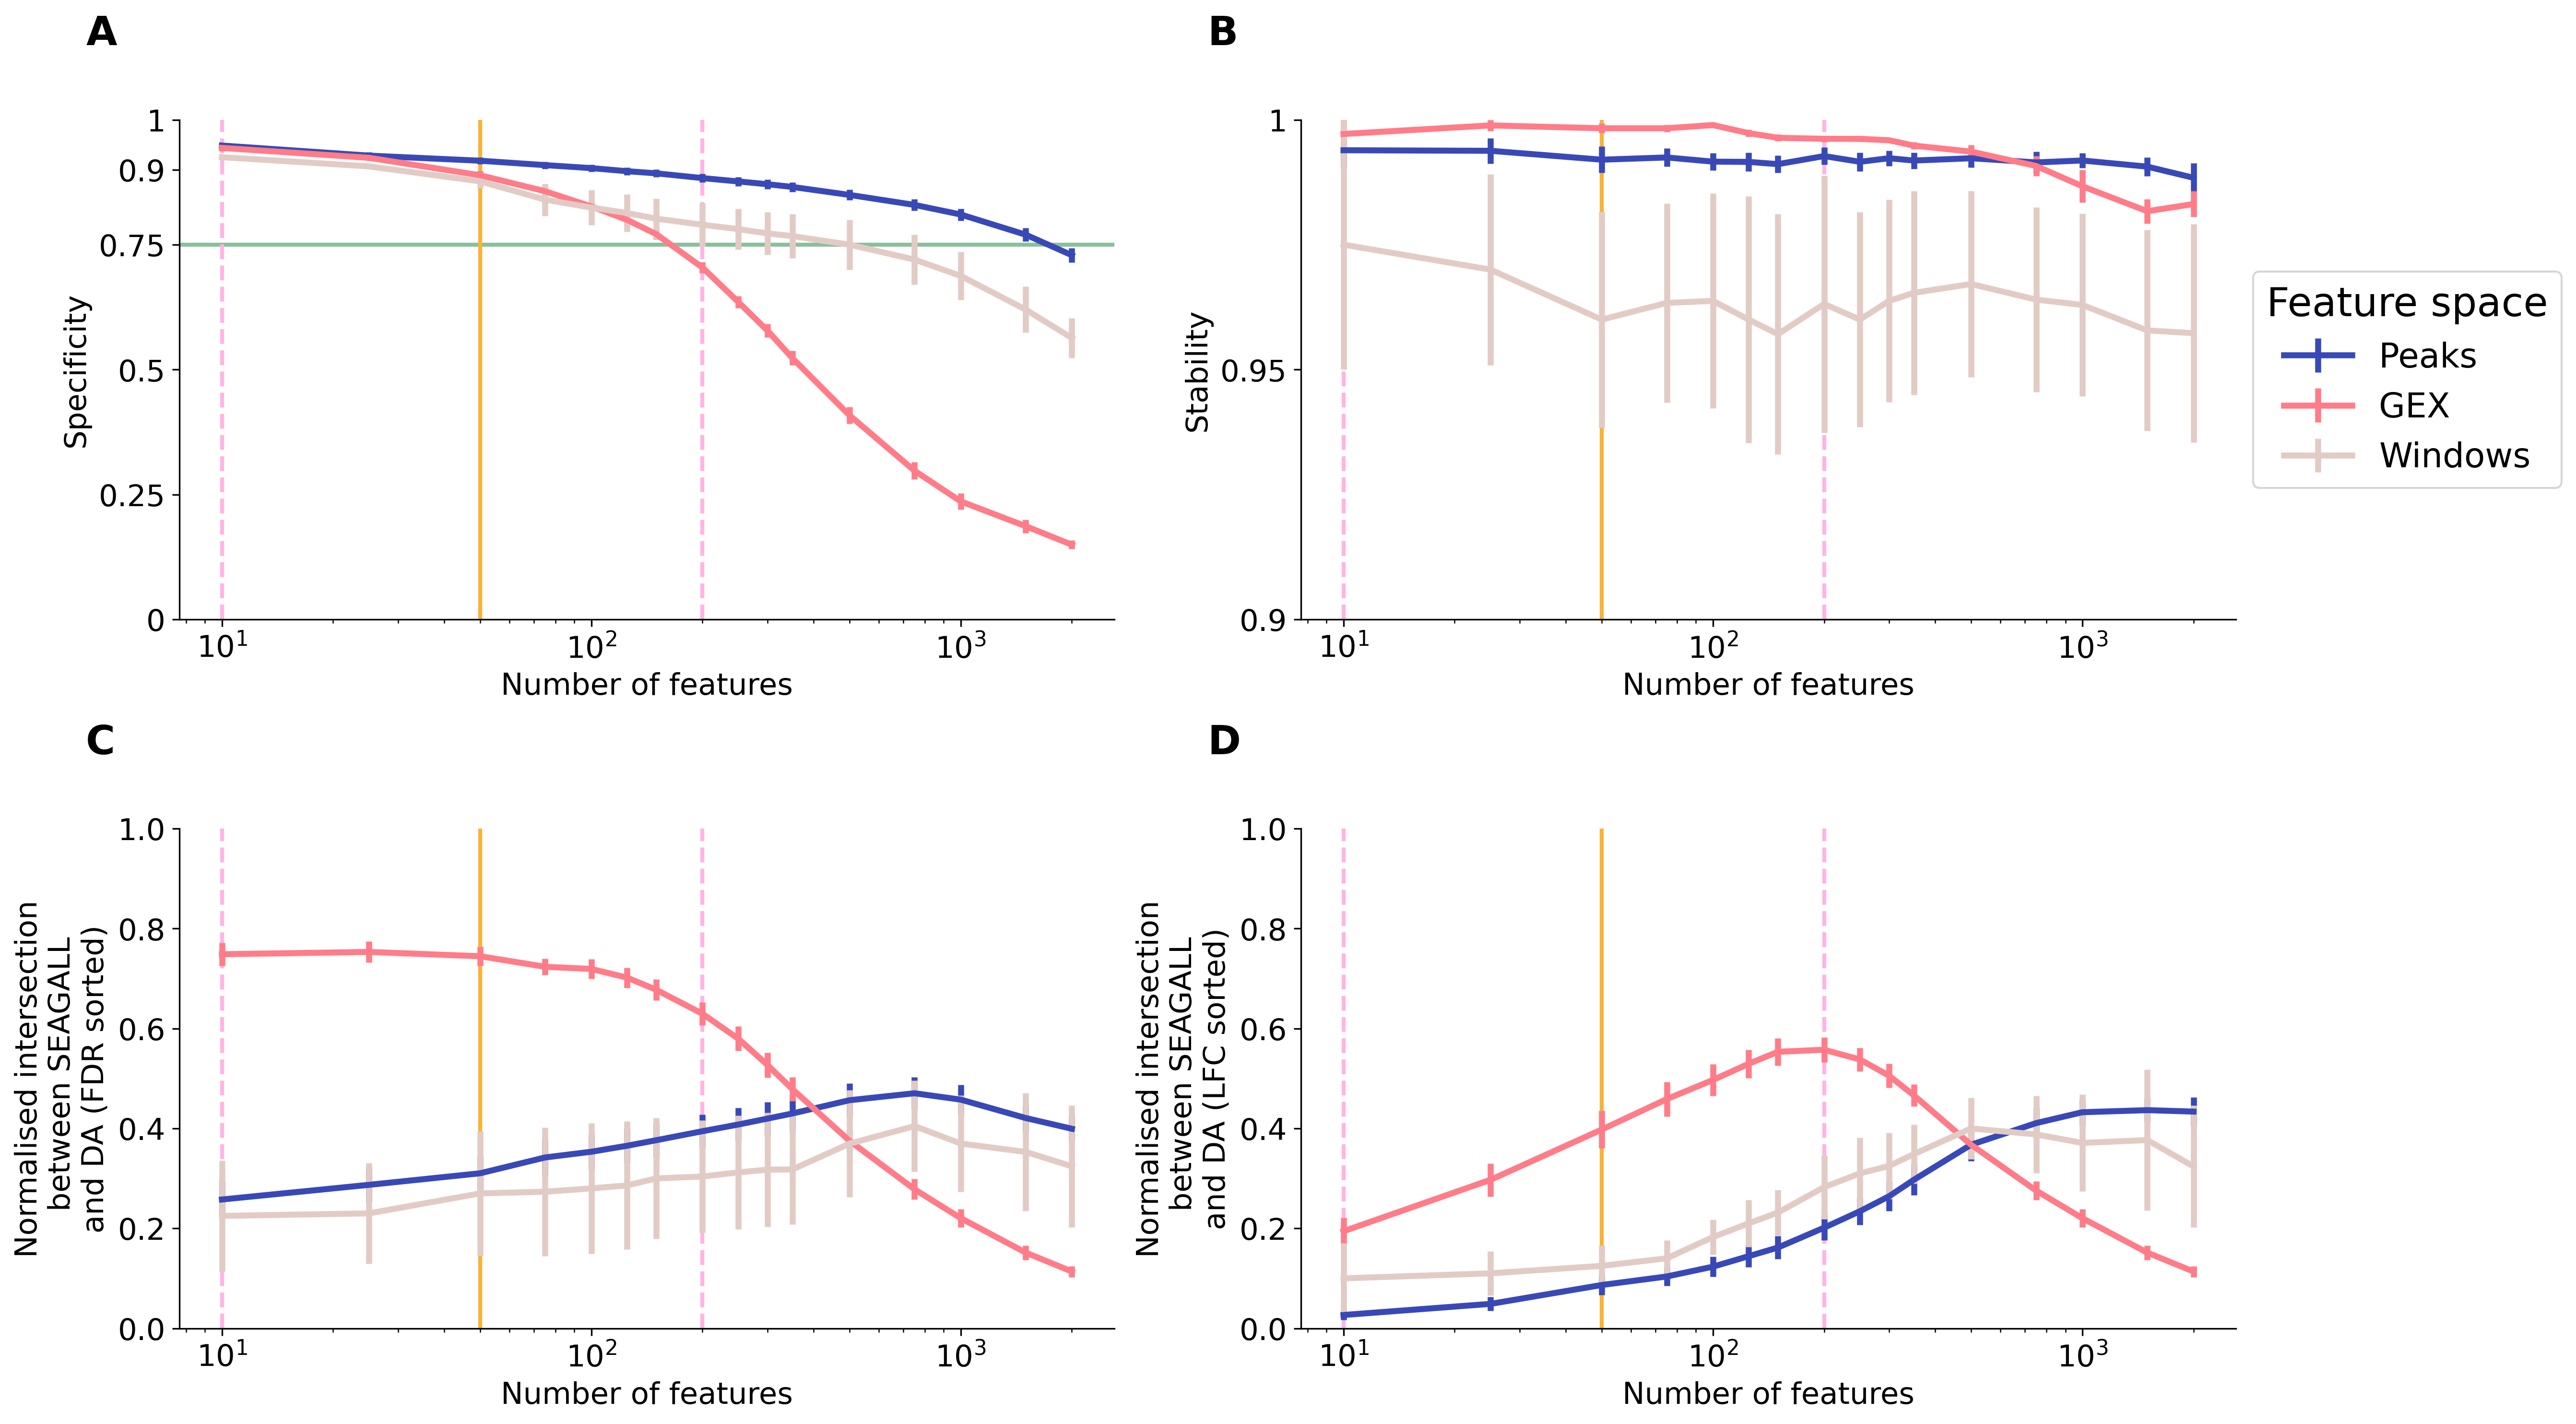

In [21]:
params = {'axes.labelsize': 15,
         'axes.titlesize': 15,
         'xtick.labelsize' : 15,
         'ytick.labelsize': 15,
         "lines.linewidth" : 4,
         "figure.dpi" : 300,
         "figure.figsize": [18, 10]}
plt.rcParams.update(params) 
fs_order=["Peaks","GEX","Windows"]
feats_palette = {fs_order[i] : ut.colors_to_use_bright[9:12][i] for i in range(len(fs_order))}
fig, axs = plt.subplots(2,2)
axs=axs.flatten()

for feat in fs_order:   
    axs[0].errorbar(x=thres, y=tot[tot["FeaturesSpace"]==feat].groupby("Threshold")["Specificity"].mean(),
                    yerr=tot[tot["FeaturesSpace"]==feat].groupby("Threshold")["Specificity"].sem(), 
               c=feats_palette[feat], zorder=10, label=feat, linewidth=3)
axs[0].set_ylabel("Specificity")
axs[0].set_xscale("log")
axs[0].axhline(y=0.75, xmin=0, xmax=5000, color=ut.colors_to_use_pastel[-6], linestyle="-", zorder=1, linewidth = 2)
axs[0].set_ylim([0, 1])
axs[0].set_yticks([0, 0.25, 0.5, 0.75, 0.9,1], [0, 0.25, 0.5, 0.75, 0.9,1])

for feat in fs_order:   
    axs[1].errorbar(x=thres, y=tot[tot["FeaturesSpace"]==feat].groupby("Threshold")["Stability"].mean(), 
                    yerr=tot[tot["FeaturesSpace"]==feat].groupby("Threshold")["Stability"].sem(),
               c=feats_palette[feat], zorder=10, label=feat, linewidth=3)
axs[1].set_ylabel("Stability")
axs[1].set_xscale("log")
axs[1].set_ylim([0.9, 1])
axs[1].set_yticks([0.9, 0.95,1], [0.9, 0.95, 1])
axs[1].legend(bbox_to_anchor=(1, 0.73), title="Feature space", fontsize=17, title_fontsize=20)


for feat in fs_order:   
    axs[2].errorbar(x=thres, y=xaiother[xaiother["FeaturesSpace"]==feat].groupby("Threshold")["Similarity"].mean(),
                    yerr=xaiother[xaiother["FeaturesSpace"]==feat].groupby("Threshold")["Similarity"].sem(),
               c=feats_palette[feat], zorder=10, label=feat, linewidth=3)
axs[2].set_ylim([0,1])
axs[2].set_xscale("log")
axs[2].set_ylabel("Normalised intersection\n between SEAGALL\nand DA (FDR sorted)")

for feat in fs_order:   
    axs[3].errorbar(x=thres, y=xaiother_lfc[xaiother_lfc["FeaturesSpace"]==feat].groupby("Threshold")["Similarity"].mean(),
                    yerr=xaiother_lfc[xaiother_lfc["FeaturesSpace"]==feat].groupby("Threshold")["Similarity"].sem(),
               c=feats_palette[feat], zorder=10, label=feat, linewidth=3)
axs[3].set_ylim([0,1])
axs[3].set_xscale("log")
axs[3].set_ylabel("Normalised intersection\n between SEAGALL\nand DA (LFC sorted)")


for i in range(0,4):
    axs[i].axvline(x=10, ymin=0, ymax=1, color=ut.colors_to_use_pastel[3], linestyle="--", zorder=1, linewidth = 2)
    axs[i].axvline(x=50, ymin=0, ymax=1, color=ut.colors_to_use_bright[-6], linestyle="-", zorder=1, linewidth = 2)
    axs[i].axvline(x=200, ymin=0, ymax=1, color=ut.colors_to_use_pastel[3], linestyle="--", zorder=1, linewidth = 2)
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)   
    axs[i].set_xlabel("Number of features")
    axs[i].text(-0.1, 1.15, string.ascii_uppercase[i], transform=axs[i].transAxes, size=20, weight='bold',rotation=0)    
    

fig.tight_layout()
plt.savefig("Figures/SEAGALL_SuppFig8.png", format="png", dpi=300, bbox_inches='tight')
plt.show()

## SEAGALL_SuppFig10

In [22]:
tot=pd.DataFrame(columns=["Dataset","FeaturesSpace", "CT", "Difference","Name"])
for dataset, featurespace, label, name in zip(ds_infos["DSs"], ds_infos["FsSs"], ds_infos["LBs"], ds_infos["Names"]):
    data=pd.DataFrame(columns=tot.columns)
    nn=f"Datasets/{dataset}/FeatureSpaces/{featurespace}/XAI/{dataset}_{featurespace}_GRAE_kNN_{label}_HPO_NN_XAIFeatures.tsv.gz"
    gnn=f"Datasets/{dataset}/FeatureSpaces/{featurespace}/XAI/{dataset}_{featurespace}_GRAE_kNN_{label}_HPO_XAITop50Features.tsv.gz"
    if os.path.isfile(gnn) == True & os.path.isfile(nn) == True:
        nn=pd.read_csv(nn, sep="\t", index_col=0)[:50]
        gnn=pd.read_csv(gnn, sep="\t", index_col=0)[:50]
        inter=ut.intersection([nn.columns, gnn.columns])
        for col in inter:
            d=pd.DataFrame(index=tot.columns, data=[dataset, featurespace, col, 1-len(ut.intersection([nn[col], gnn[col]]))/50, name]).T
            tot=pd.concat([tot, d])
    else:
        print(nn, gnn)

tot1=pd.DataFrame(columns=["Dataset","FeaturesSpace", "CT", "Difference","Name"])
for dataset, featurespace, label, name in zip(ds_infos["DSs"], ds_infos["FsSs"], ds_infos["LBs"], ds_infos["Names"]):
    data=pd.DataFrame(columns=tot1.columns)
    grae=f"Datasets/{dataset}/FeatureSpaces/{featurespace}/XAI/{dataset}_{featurespace}_GRAE_kNN_{label}_HPO_XAITop50Features.tsv.gz"
    ae=f"Datasets/{dataset}/FeatureSpaces/{featurespace}/XAI/{dataset}_{featurespace}_AE_kNN_{label}_HPO_XAITop50Features.tsv.gz"
    if os.path.isfile(grae) == True & os.path.isfile(ae) == True:
        grae=pd.read_csv(grae, sep="\t", index_col=0)[:50]
        ae=pd.read_csv(ae, sep="\t", index_col=0)[:50]
        inter=ut.intersection([grae.columns, ae.columns])
        for col in inter:
            d=pd.DataFrame(index=tot1.columns, data=[dataset, featurespace, col, 1-len(ut.intersection([grae[col], ae[col]]))/50, name]).T
            tot1=pd.concat([tot1, d])
    else:
        print(grae, ae)

tot["FeaturesSpace"]=tot["FeaturesSpace"].replace("Peak","Peaks")
tot["FeaturesSpace"]=tot["FeaturesSpace"].replace("Window","Windows")
tot1["FeaturesSpace"]=tot1["FeaturesSpace"].replace("Peak","Peaks")
tot1["FeaturesSpace"]=tot1["FeaturesSpace"].replace("Window","Windows")

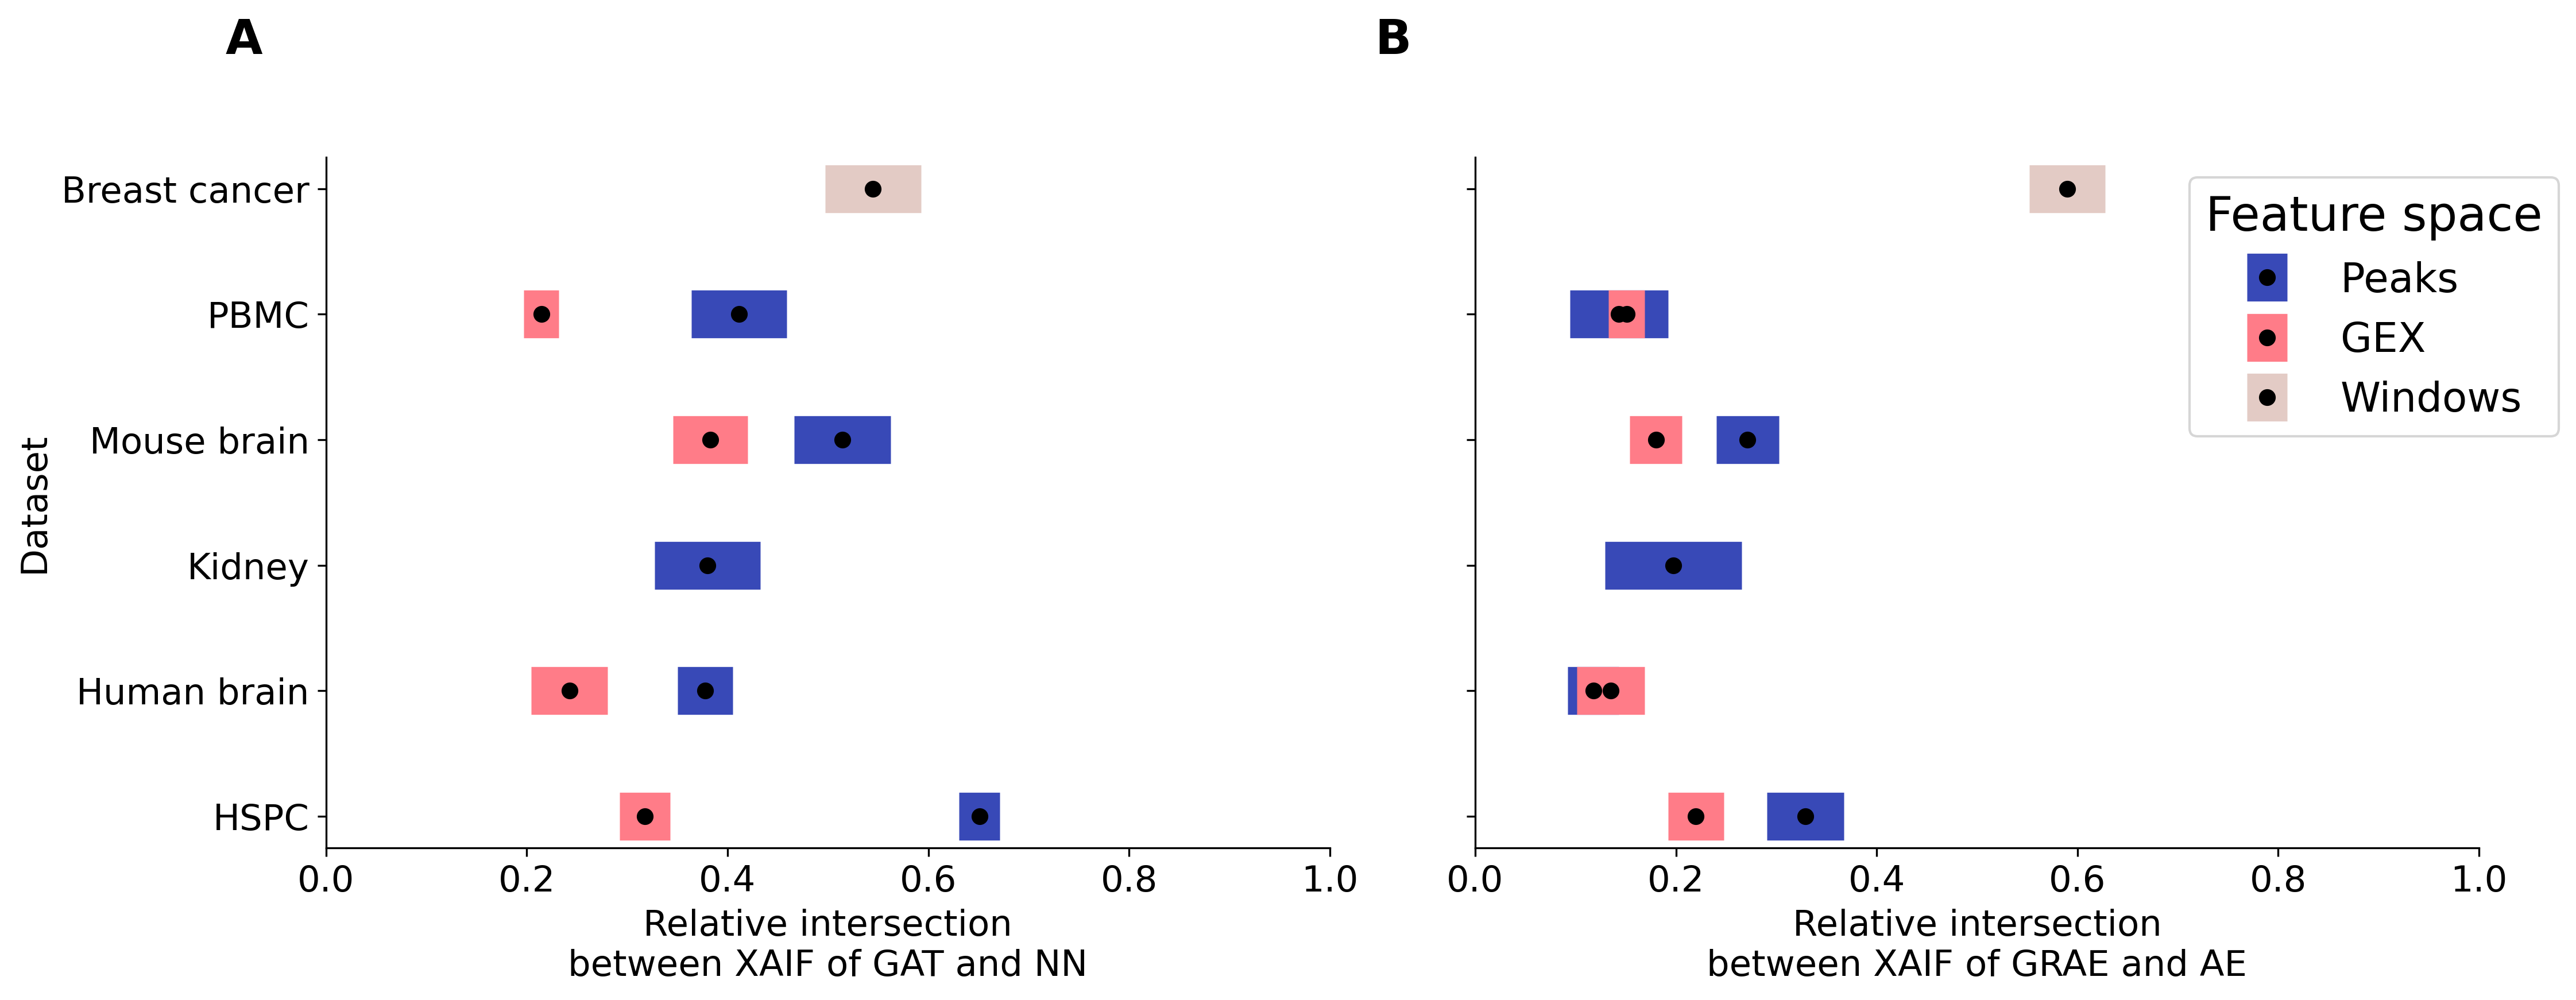

In [23]:
params = {'axes.labelsize': 15,
         'axes.titlesize': 15,
         'xtick.labelsize' : 15,
         'ytick.labelsize': 15,
         "lines.linewidth" : 4,
         "figure.dpi" : 300,
         "figure.figsize": [15, 6]}
plt.rcParams.update(params) 
fig, axs = plt.subplots(1,2, sharey=True)

for i,fs in enumerate(["Peaks","GEX","Windows"]):
    d=tot[tot["FeaturesSpace"]==fs]
    order=sorted(set(d["Name"]))
    means=np.array(d.groupby("Name")["Difference"].mean())
    sems=np.array(d.groupby("Name")["Difference"].sem())
    axs[0].errorbar(x=means, y=order, xerr=sems,ls='none', ecolor=ut.colors_to_use_bright[9:12][i], 
                    elinewidth=20, marker="o", c="black", label=fs)

    d=tot1[tot1["FeaturesSpace"]==fs]
    order=sorted(set(d["Name"]))
    means=np.array(d.groupby("Name")["Difference"].mean())
    sems=np.array(d.groupby("Name")["Difference"].sem())
    axs[1].errorbar(x=means, y=order, xerr=sems,ls='none', ecolor=ut.colors_to_use_bright[9:12][i], 
                    elinewidth=20, marker="o", c="black", label=fs)

axs[0].set_ylabel("Dataset")
axs[0].set_xlabel("Relative intersection\nbetween XAIF of GAT and NN")
axs[0].set_xlim([0,1])
axs[0].legend().remove()

axs[1].set_xlabel("Relative intersection\nbetween XAIF of GRAE and AE")
axs[1].legend(bbox_to_anchor=(1.1, 1), title="Feature space", fontsize=17, title_fontsize=20)
axs[1].set_xlim([0,1])
for i in range(0,2):
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)   
    axs[i].text(-0.1, 1.15, string.ascii_uppercase[i], transform=axs[i].transAxes, size=20, weight='bold',rotation=0)    

fig.tight_layout()
plt.savefig("Figures/SEAGALL_SuppFig10.png", format="png", dpi=300, bbox_inches='tight')
plt.show()

## SEAGALL_SuppFig11

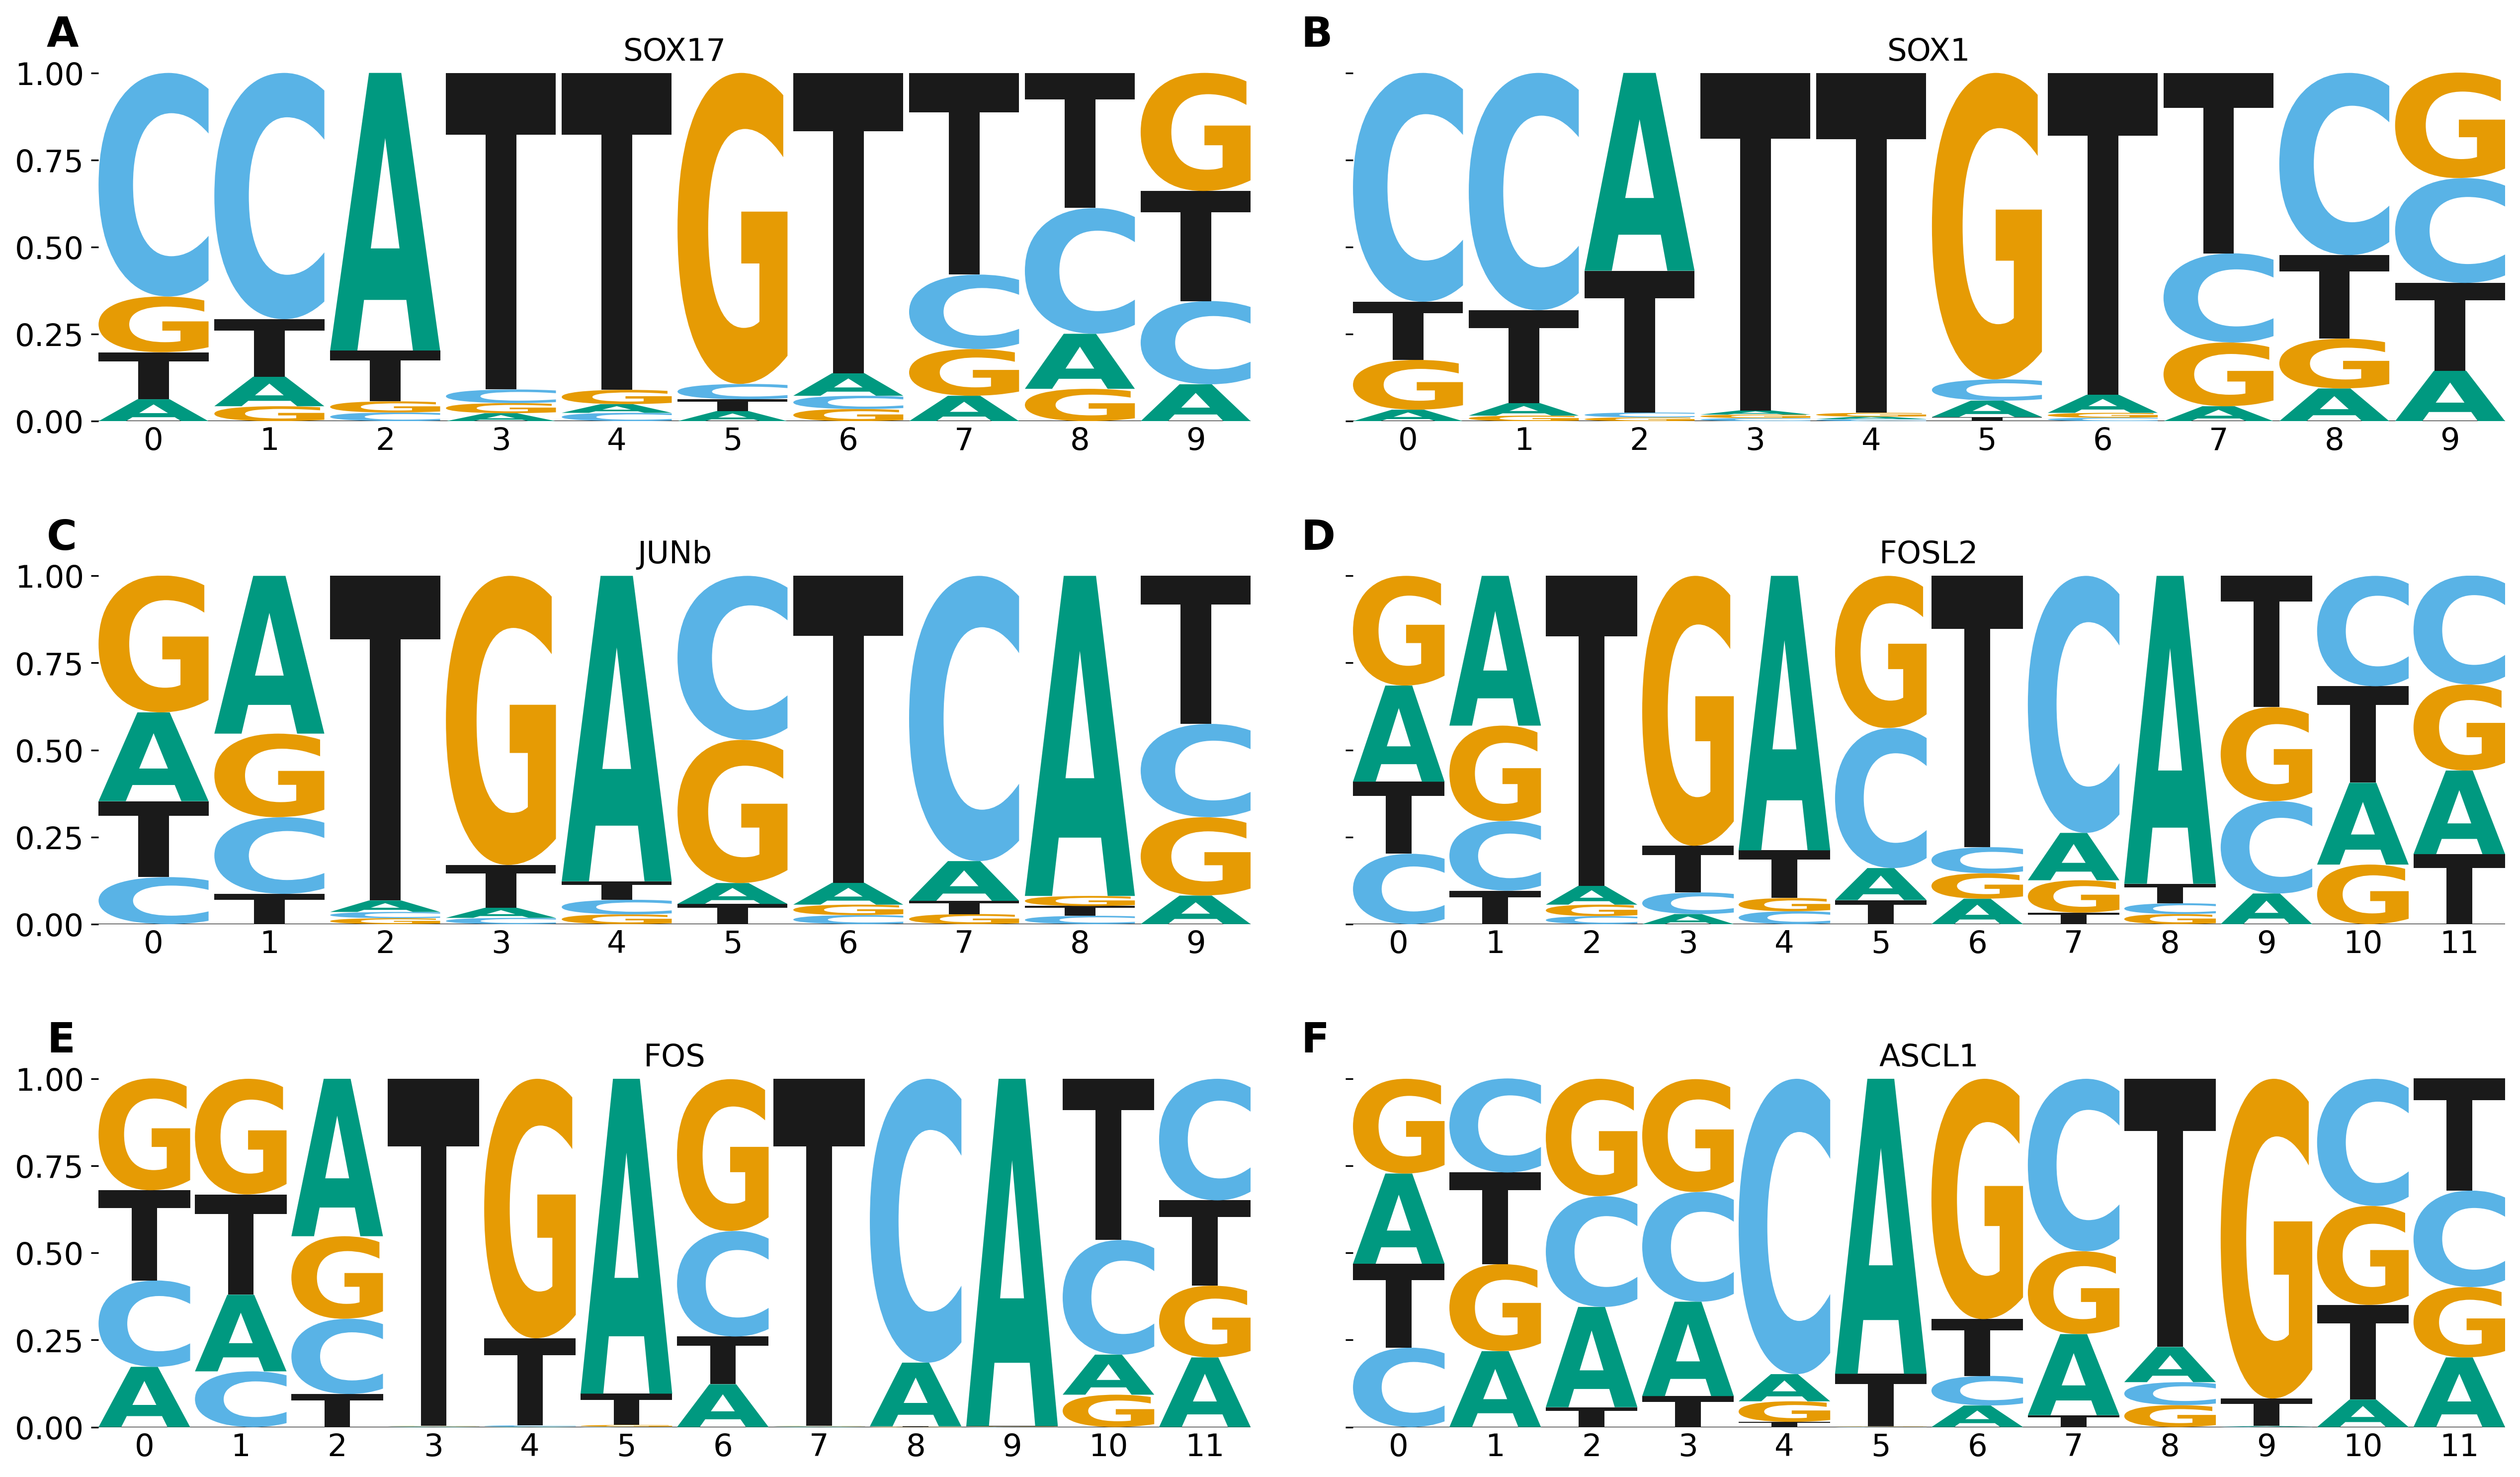

In [24]:
SOX9 = pd.read_csv('Datasets/10XhsBrain3kMO/FeatureSpaces/Peak/XAI/MotifAnalysis/HOMER_XAIonly/Astrocyte_progenitor/knownResults/known3.motif',
                 sep="\t", header=None, names=["A","C","G","T"], skiprows=1)
SOX17 = pd.read_csv('Datasets/10XhsBrain3kMO/FeatureSpaces/Peak/XAI/MotifAnalysis/HOMER_XAIonly/Astrocyte_progenitor/knownResults/known5.motif',
                 sep="\t", header=None, names=["A","C","G","T"], skiprows=1)
SOX1 = pd.read_csv('Datasets/10XhsBrain3kMO/FeatureSpaces/Peak/XAI/MotifAnalysis/HOMER_XAIonly/Astrocyte_progenitor/knownResults/known7.motif',
                   sep="\t", header=None, names=["A","C","G","T"], skiprows=1)

ASCL1 = pd.read_csv('Datasets/10XhsBrain3kMO/FeatureSpaces/Peak/XAI/MotifAnalysis/HOMER_XAIonly/Inhibitory_neuron_MAF/knownResults/known14.motif',
                 sep="\t", header=None, names=["A","C","G","T"], skiprows=1)

JUNb = pd.read_csv('Datasets/10XhsBrain3kMO/FeatureSpaces/Peak/XAI/MotifAnalysis/HOMER_XAIonly/Microglia/knownResults/known12.motif',
                 sep="\t", header=None, names=["A","C","G","T"], skiprows=1)
FOSL2 = pd.read_csv('Datasets/10XhsBrain3kMO/FeatureSpaces/Peak/XAI/MotifAnalysis/HOMER_XAIonly/Microglia/knownResults/known15.motif',
                 sep="\t", header=None, names=["A","C","G","T"], skiprows=1)
FOS = pd.read_csv('Datasets/10XhsBrain3kMO/FeatureSpaces/Peak/XAI/MotifAnalysis/HOMER_XAIonly/Microglia/knownResults/known16.motif',
                 sep="\t", header=None, names=["A","C","G","T"], skiprows=1)
logos=[SOX17, SOX1, JUNb, FOSL2, FOS, ASCL1]
names=["SOX17","SOX1","JUNb", "FOSL2", "FOS", "ASCL1"]
fig, axs = plt.subplots(3,2, figsize=(17, 10), dpi=300, sharey=True)
axs=axs.flatten()
for i, log in enumerate(logos):
    crp_logo1 = logomaker.Logo(log, shade_below=.5,fade_below=.5, ax=axs[i], color_scheme="colorblind_safe")
    crp_logo1.style_spines(visible=False)
    crp_logo1.style_xticks(fmt='%d', anchor=0)
    crp_logo1.ax.xaxis.set_ticks_position('none')
    crp_logo1.ax.xaxis.set_tick_params(pad=-1)
    axs[i].set_title(names[i])
    axs[i].text(-0.045, 1.075, string.ascii_uppercase[i], transform=axs[i].transAxes, size=20, weight='bold',rotation=0)
fig.tight_layout(w_pad=3, h_pad=3)
plt.savefig("Figures/SEAGALL_SuppFig11.png", format="png", dpi=300, bbox_inches='tight')
plt.show()

In [117]:
dss=["10XhsBrain3kMO", "10XhsBrain3kMO", "10XhsBrain3kMO", "10XhsPBMC10kMO"]
names=["Human brain","Human brain","Human Brain","PBMC"]
cts=["Astrocyte_progenitor", "Inhibitory_neuron_MAF", "Microglia", "DCp"]
cols=['Motif Name', 'Consensus','q-value (Benjamini)']
order=['Data set',
 'Cell type',
 'DA Motif Name',
 'DA Consensus',
 'DA q-value (Benjamini)',
 'SEAGALL Motif Name',
 'SEAGALL Consensus',
 'SEAGALL q-value (Benjamini)',
 'SnapATAC2 Motif Name',
 'SnapATAC2 Consensus',
 'SnapATAC2 q-value (Benjamini)']
tot=pd.DataFrame()
for ds, ct, n, in zip(dss, cts, names):
    print(ds, ct)
    xai=pd.read_csv(f"Datasets/{ds}/FeatureSpaces/Peak/XAI/MotifAnalysis/HOMER_XAIonly/{ct}/knownResults.txt", sep="\t")
    de=pd.read_csv(f"Datasets/{ds}/FeatureSpaces/Peak/XAI/DE/MotifAnalysis/HOMER_DEonly/{ct}/knownResults.txt", sep="\t")
    snp2=f"Datasets/{dataset}/FeatureSpaces/{featurespace}/XAI/SnapATAC2/{dataset}_{featurespace}_Features.tsv.gz"

    xai=xai[xai["q-value (Benjamini)"]<0.05][cols]
    de=de[de["q-value (Benjamini)"]<0.05][cols]
    snp2=snp2[snp2["q-value (Benjamini)"]<0.05][cols]

    xai.columns = [f"SEAGALL {col}" for col in xai.columns]
    de.columns = [f"DA {col}" for col in de.columns]
    snp2.columns = [f"SnapATAC2 {col}" for col in snp2.columns]
    xai["Data set"]=n
    xai["Cell type"]=ct
    de["Data set"]=n
    de["Cell type"]=ct
    snp2["Data set"]=n
    snp2["Cell type"]=ct
    df=pd.concat([de, xai, snp2])
    df.reset_index(inplace=True)
    df.drop("index", axis=1, inplace=True)
    tot=pd.concat([df, tot], axis=0)
    df.to_csv(f"Tables/Motif/{ds}_{ct}.tsv", sep="\t", index=None)
tot=tot[order]
tot.reset_index(inplace=True)
tot.drop("index", axis=1, inplace=True)
tot.to_csv("Tables/MotifTable.tsv", sep="\t", index=None)

10XhsBrain3kMO Astrocyte_progenitor
10XhsBrain3kMO Inhibitory_neuron_MAF
10XhsBrain3kMO Microglia
10XhsPBMC10kMO DCp


## SEAGALL_SuppFig12

In [25]:
brain=sc.read_h5ad("Datasets/10XhsBrain3kMO//FeatureSpaces/GEX/CM/10XhsBrain3kMO_GEX_Def.h5ad")
brain_atac=sc.read_h5ad("Datasets/10XhsBrain3kMO/FeatureSpaces/Peak/CM/10XhsBrain3kMO_Peak_Def.h5ad")

pbmc=sc.read_h5ad("Datasets/10XhsPBMC10kMO/FeatureSpaces/GEX/CM/10XhsPBMC10kMO_GEX_Def.h5ad")
pbmc_atac=sc.read_h5ad("Datasets/10XhsPBMC10kMO/FeatureSpaces/Peak/CM/10XhsPBMC10kMO_Peak_Def.h5ad")

In [26]:
inter=ut.intersection([brain_atac.obs.index, brain.obs.index])
brain_atac=brain_atac[inter]
brain=brain[inter]
brain.obsm["X_umap"]=np.array([brain_atac.obsm["X_GRAE_2D"].T[0]*-1, brain_atac.obsm["X_GRAE_2D"].T[1]]).T
brain.obs["CT"]=brain.obs.CellType
brain.obs["CT"].replace({"Astrocyte": "Astrocytes", "Astrocyte_progenitor" : "Astrocytes progenitors"}, inplace=True)

In [27]:
params = {'axes.labelsize': 15,
         'axes.titlesize': 15,
         'xtick.labelsize' : 15,
         'ytick.labelsize': 15,
         "lines.linewidth" : 4,
         "figure.dpi" : 300,
         "figure.figsize": [18, 5]}
plt.rcParams.update(params) 
fig, axs = plt.subplots(1,3)
axs=axs.flatten()

cts_colors={}
for i,ct in enumerate(list(set(brain.obs.CT))):
    cts_colors[ct]=ut.colors_to_use_pastel[i]
cts_colors["Astrocytes"]=ut.colors_to_use_bright[-6]
cts_colors["Astrocytes progenitors"]=ut.colors_to_use_bright[-4]
cts_colors["Inhibitory_neuron_PVALB_SST"]=ut.colors_to_use_pastel[-2]
cts_colors["Microglia"]=ut.colors_to_use_bright[1]


cmap=mpl.cm.inferno

sc.pl.umap(brain, color="CT", ax=axs[0], frameon=True, show=False, palette=cts_colors, legend_fontsize=13, size=200,
          legend_loc="right margin", alpha=0.7)
axs[0].legend(bbox_to_anchor=(-0.1, 1), title="", fontsize=12, frameon=False)
axs[0].set_title("")
ax=sc.pl.umap(brain, color="TLR2", ax=axs[1], frameon=False, show=False, legend_fontsize=10, size=200, vmin=0, vmax=2.5,
              color_map=cmap, colorbar_loc=None)

ax=sc.pl.umap(brain, color="RIPK2", ax=axs[2], frameon=False, show=False, vmin=0, vmax=2.5, 
              legend_fontsize=10, size=200, color_map=cmap, colorbar_loc=None)
sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_clim(vmin=0, vmax=2.5)
fig.colorbar(ax=ax, mappable=sm, label="Log norm. counts", ticks=[0, 0.5, 1, 1.5, 2, 2.5])

for i in range(0,3):
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
    axs[i].spines['left'].set_visible(False)
    axs[i].spines['bottom'].set_visible(False)
    if i == 0:
        axs[i].set_xlabel("GRAE-1", labelpad=20)
        axs[i].set_ylabel("GRAE-2")
    axs[i].text(-0.1, 1.15, string.ascii_uppercase[i], transform=axs[i].transAxes, size=20, weight='bold',rotation=0)  

fig.tight_layout(w_pad=-0.5)
plt.savefig("Figures/SEAGALL_SuppFig12_Up.png", format="png", dpi=300, bbox_inches='tight')
plt.show()

In [28]:
inter=ut.intersection([pbmc_atac.obs.index, pbmc.obs.index])
pbmc_atac=pbmc_atac[inter]
pbmc=pbmc[inter]
pbmc.obsm["X_umap"]=np.array([pbmc_atac.obsm["X_GRAE_2D"].T[0]*-1, pbmc_atac.obsm["X_GRAE_2D"].T[1]]).T
pbmc.obs["CT"]=pbmc.obs.CellType

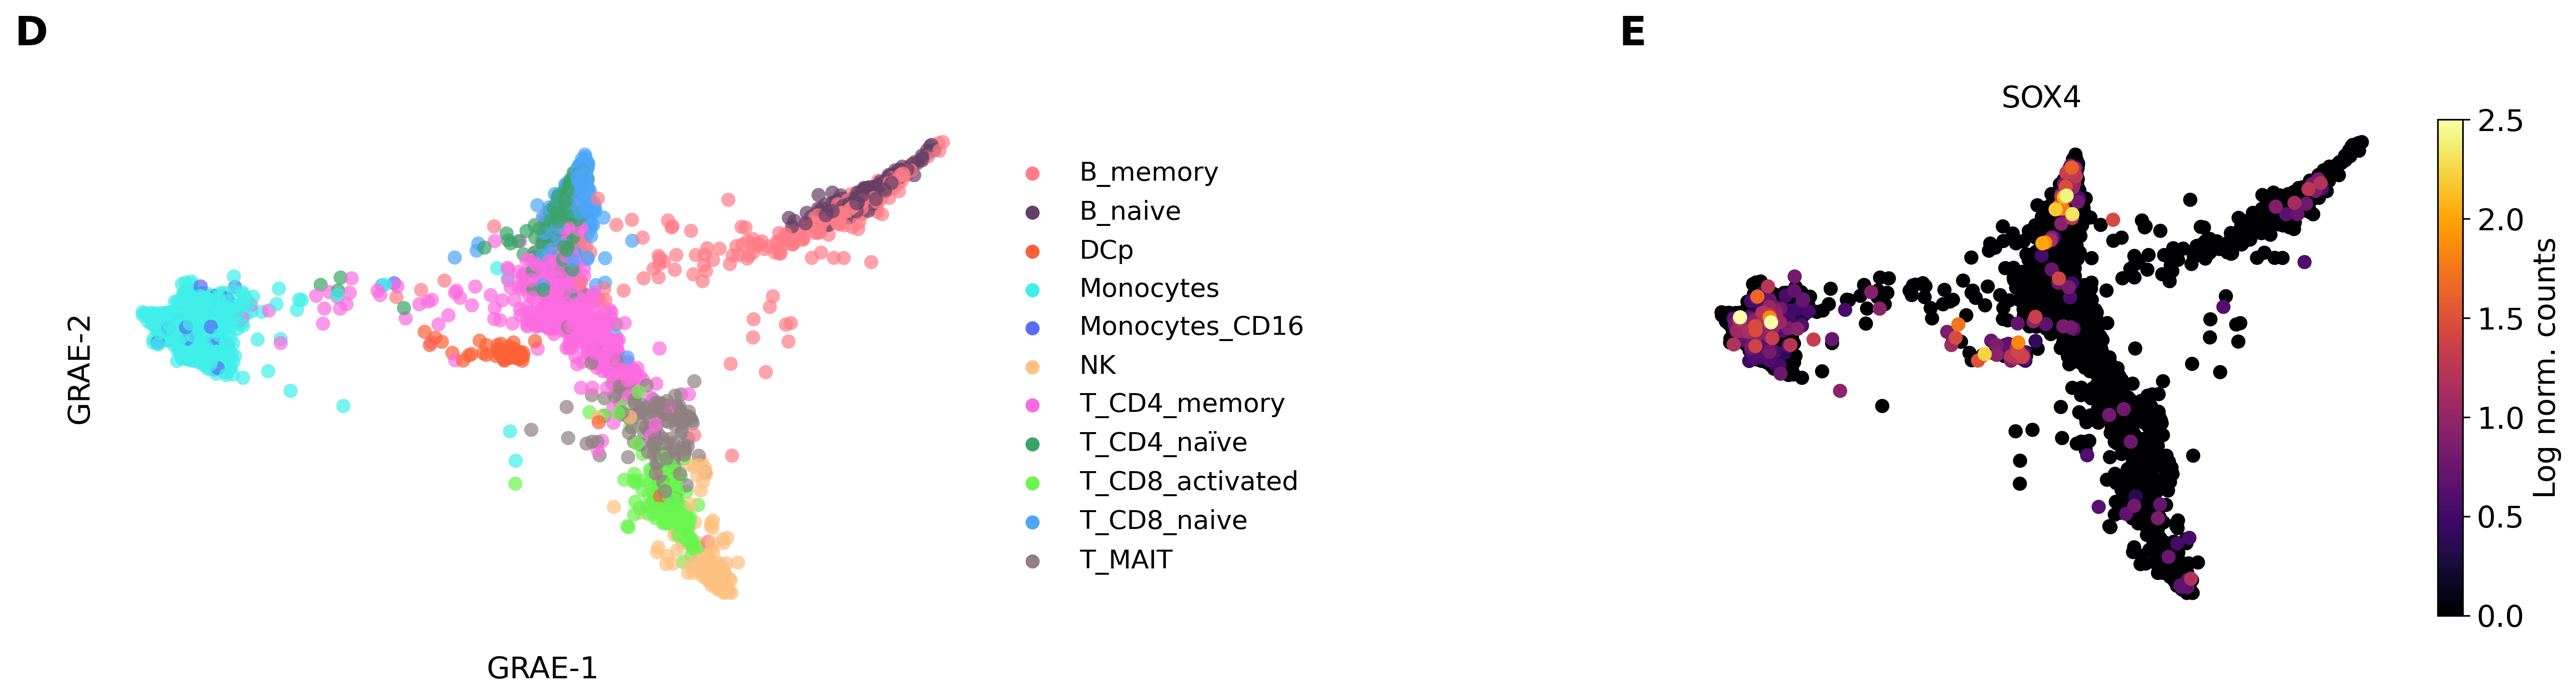

In [29]:
params = {'axes.labelsize': 15,
         'axes.titlesize': 15,
         'xtick.labelsize' : 15,
         'ytick.labelsize': 15,
         "lines.linewidth" : 4,
         "figure.dpi" : 300,
         "figure.figsize": [18, 5]}
plt.rcParams.update(params) 
fig, axs = plt.subplots(1,2)
axs=axs.flatten()

cts_colors={}
for i,ct in enumerate(list(set(pbmc.obs.CellType))):
    cts_colors[ct]=ut.colors_to_use_bright[i]
cts_colors["T_MAIT"]=ut.colors_to_use_pastel[0]
cts_colors["NK"]=ut.colors_to_use_pastel[1]

cmap=mpl.cm.inferno

sc.pl.umap(pbmc, color="CellType", ax=axs[0], frameon=True, show=False, palette=cts_colors, legend_fontsize=13, size=200,
          legend_loc="right margin", alpha=0.7)
#axs[0].legend(bbox_to_anchor=(-0.05, 1), title="", fontsize=12, title_fontsize=20)
axs[0].set_title("")

ax=sc.pl.umap(pbmc, color="SOX4", ax=axs[1], frameon=False, show=False, legend_fontsize=10, size=200, vmin=0, vmax=2.5,
              color_map=cmap, colorbar_loc=None)
sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_clim(vmin=0, vmax=2.5)
fig.colorbar(ax=ax, mappable=sm, label="Log norm. counts", ticks=[0, 0.5, 1, 1.5, 2, 2.5])


for i in range(0,2):
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
    axs[i].spines['left'].set_visible(False)
    axs[i].spines['bottom'].set_visible(False)
    if i == 0:
        axs[i].set_xlabel("GRAE-1", labelpad=20)
        axs[i].set_ylabel("GRAE-2")
    axs[i].text(-0.1, 1.15, string.ascii_uppercase[i+3], transform=axs[i].transAxes, size=20, weight='bold',rotation=0)  

fig.tight_layout(w_pad=15)
plt.savefig("Figures/SEAGALL_SuppFig12_Middle.png", format="png", dpi=300, bbox_inches='tight')
plt.show()

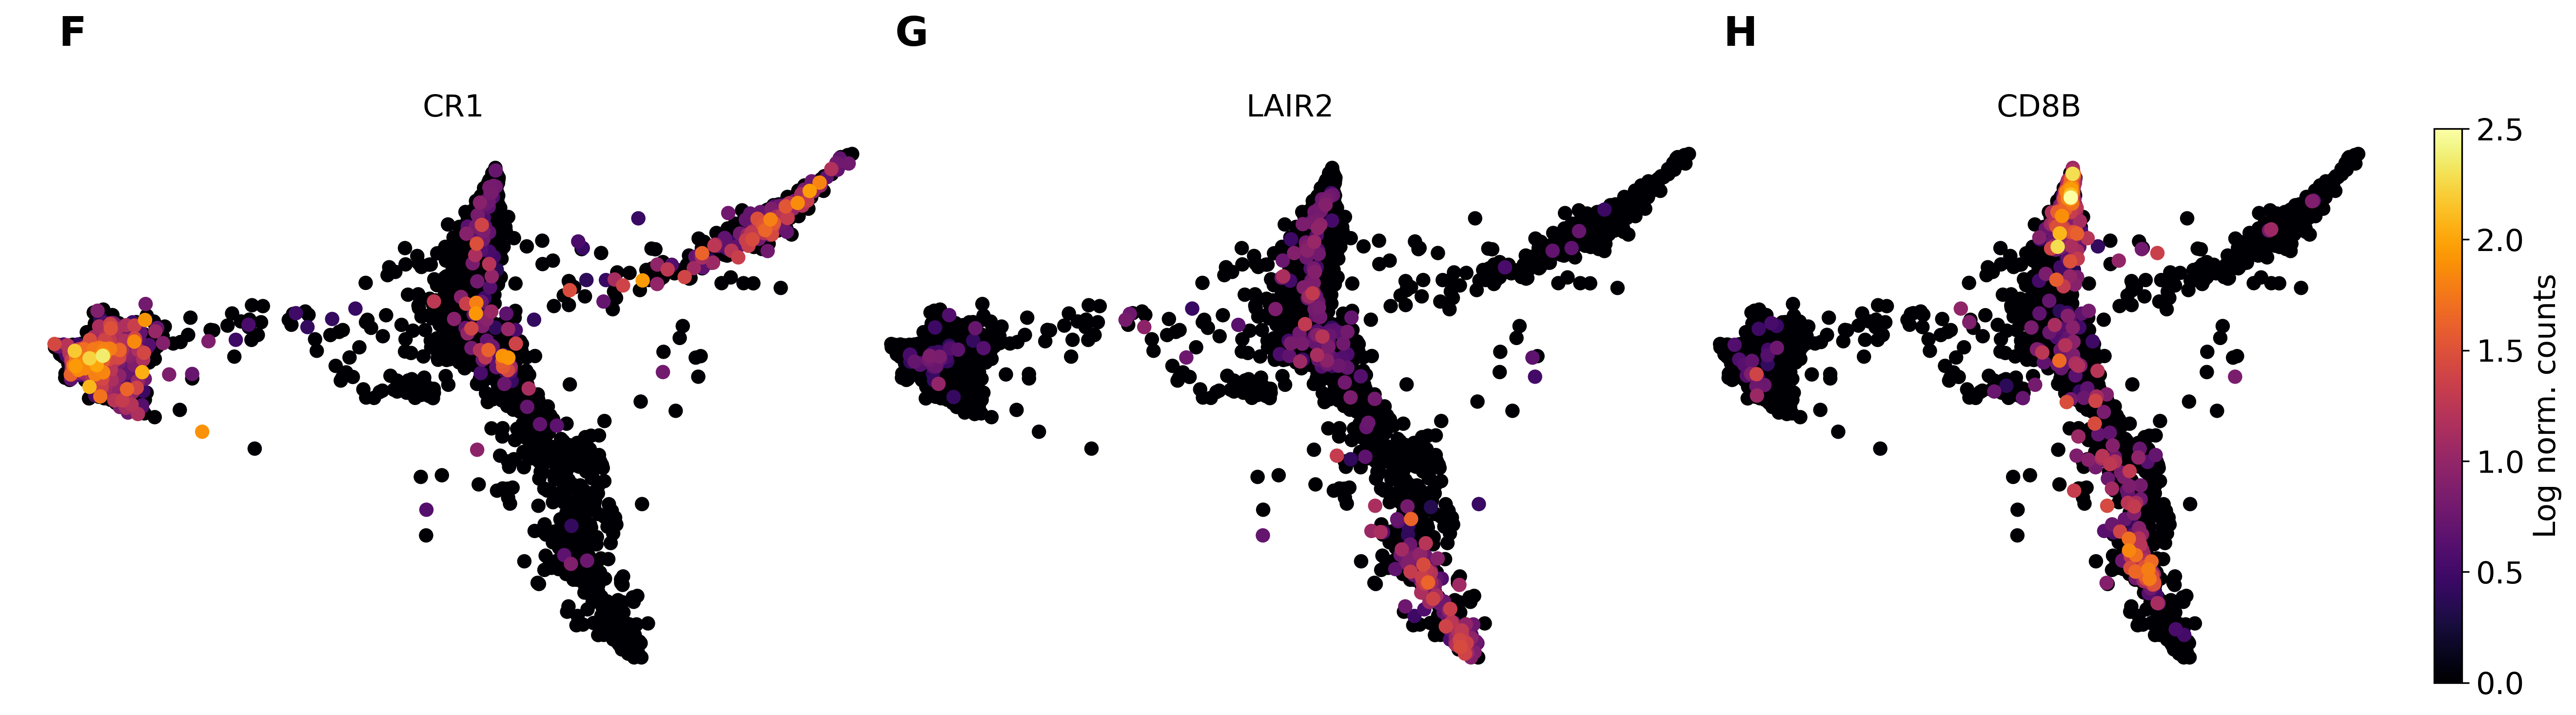

In [30]:
params = {'axes.labelsize': 15,
         'axes.titlesize': 15,
         'xtick.labelsize' : 15,
         'ytick.labelsize': 15,
         "lines.linewidth" : 4,
         "figure.dpi" : 300,
         "figure.figsize": [18, 5]}
plt.rcParams.update(params) 
fig, axs = plt.subplots(1,3)
axs=axs.flatten()

cts_colors={}
for i,ct in enumerate(list(set(pbmc.obs.CellType))):
    cts_colors[ct]=ut.colors_to_use_bright[i]
cts_colors["T_MAIT"]=ut.colors_to_use_pastel[0]
cts_colors["NK"]=ut.colors_to_use_pastel[1]

cmap=mpl.cm.inferno

ax=sc.pl.umap(pbmc, color="CR1", ax=axs[0], frameon=False, show=False, legend_fontsize=10, size=200, vmin=0, vmax=2.5,
              color_map=cmap, colorbar_loc=None)
ax=sc.pl.umap(pbmc, color="LAIR2", ax=axs[1], frameon=False, show=False, vmin=0, vmax=2.5, 
              legend_fontsize=10, size=200, color_map=cmap, colorbar_loc=None)
ax=sc.pl.umap(pbmc, color="CD8B", ax=axs[2], frameon=False, show=False, vmin=0, vmax=2.5, 
              legend_fontsize=10, size=200, color_map=cmap, colorbar_loc=None)
sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_clim(vmin=0, vmax=2.5)
fig.colorbar(ax=ax, mappable=sm, label="Log norm. counts", ticks=[0, 0.5, 1, 1.5, 2, 2.5])

for i in range(0,3):
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
    axs[i].spines['left'].set_visible(False)
    axs[i].spines['bottom'].set_visible(False)
    axs[i].text(0.05, 1.15, string.ascii_uppercase[i+5], transform=axs[i].transAxes, size=20, weight='bold',rotation=0)  

fig.tight_layout(w_pad=-2)
plt.savefig("Figures/SEAGALL_SuppFig12_Down.png", format="png", dpi=300, bbox_inches='tight')
plt.show()

## SEGALL_SuppFig9

In [15]:
ds_infos=pd.read_csv("Tables/Datasets_infos.tsv", sep="\t", index_col=0)
datasets = {}

for dataset, featurespace, label, name in zip(
    ds_infos["DSs"], ds_infos["FsSs"], ds_infos["LBs"], ds_infos["Names"]
):
    # Keep original FS name for logic
    fs_orig = featurespace

    if featurespace != "GEX":
        method="SnapATAC2_DA"
        other_path=f"Datasets/{dataset}/FeatureSpaces/{featurespace}/XAI/SnapATAC2/{dataset}_{featurespace}_Features.tsv.gz"
    else:
        method="Scanpy_DA"
        other_path=f"Datasets/{dataset}/FeatureSpaces/{featurespace}/XAI/DE/{dataset}_{featurespace}_GRAE_kNN_{label}_DEFeatures.tsv.gz"
    xai_path=f"Datasets/{dataset}/FeatureSpaces/{featurespace}/XAI/{dataset}_{featurespace}_GRAE_kNN_{label}_HPO_XAIFeatures.tsv.gz"


    # Nice label for the panel title
    fs_label = f"{fs_orig}s" if fs_orig != "GEX" else fs_orig
    print(fs_label)
    key = f"{name}\n{fs_label}"
    datasets[key] = {}

    # Read DE & XAI
    other = pd.read_csv(other_path, sep="\t", index_col=0)
    xai = pd.read_csv(xai_path, sep="\t", index_col=0)

    # Optional: restrict to top 50 in case files have more
    other = other.iloc[:50, :]
    xai = xai.iloc[:50, :]

    # Melt, drop NaNs, turn into sets
    other_feats = set(other.melt()["value"].dropna())
    xai_feats = set(xai.melt()["value"].dropna())

    datasets[key]["SEAGALL"] = xai_feats
    datasets[key][method] = other_feats

Peaks
GEX
Windows
Peaks
GEX
Peaks
GEX
Peaks
GEX
Peaks


In [17]:
# Color mapping for the three methods
selected_colors = [(0.4502835075797788, 0.4137972479772782, 0.6667776141888558),   (0.8289219715510678, 0.41974959068753226, 0.5543085353140962), (0.6385027637736282, 0.8403347267917161, 0.5859308575921919)]

color_map = {
    "SEAGALL":   selected_colors[2],
    "Scanpy_DA":    selected_colors[1],
    "SnapATAC2_DA": selected_colors[0],
}
plt.rcParams.update(plt.rcParamsDefault)
params = {
    "figure.dpi": 300,
    "figure.figsize": [10, 8],
    "font.size": 7
}
plt.rcParams.update(params)
plt.close("all")
nrows, ncols = 2, 5
fig, axes = plt.subplots(nrows, ncols)

assert len(datasets) <= nrows * ncols, "More than 10 datasets for a 2x5 grid!"

for idx, (name, methods) in enumerate(datasets.items()):
    r, c = divmod(idx, ncols)
    ax = axes[r, c]

    # Always SEAGALL
    seagall = methods.get("SEAGALL", set())
    scanpy  = methods.get("Scanpy_DA", set())
    snap    = methods.get("SnapATAC2_DA", set())

    # Clean NaNs
    seagall = {f for f in seagall if not pd.isna(f)}
    scanpy  = {f for f in scanpy  if not pd.isna(f)}
    snap    = {f for f in snap    if not pd.isna(f)}

    # Choose the other method + its color
    if len(scanpy) > 0:
        other = scanpy
        other_label = "Scanpy_DA"
    elif len(snap) > 0:
        other = snap
        other_label = "SnapATAC2_DA"

    venn2([seagall, other], set_labels=("SEAGALL", other_label), ax=ax,
        set_colors=[color_map["SEAGALL"], color_map[other_label]], alpha=0.7)
    
axes=axes.flatten()
for idx, (name, methods) in enumerate(datasets.items()):
    letter = string.ascii_uppercase[idx]
    axes[idx].text(0.05, 1.2, rf"$\bf{{{letter}}}$" + f" - {name}", transform=axes[idx].transAxes, 
                   weight='bold',rotation=0, ha="left", va="top")  

plt.suptitle("Features", y=0.75)
plt.tight_layout(h_pad=-25)
plt.savefig("Figures/SEGALL_SuppFig9_Up.png", format="png", dpi=300, bbox_inches='tight')
plt.show()

In [18]:
ds_infos=pd.read_csv("Tables/Datasets_infos.tsv", sep="\t", index_col=0)
ds_infos=ds_infos[ds_infos["FsSs"]!="GEX"]
ds_infos=ds_infos
ds_infos
datasets = {}
cols=['Motif Name', 'Consensus','q-value (Benjamini)']
for ds, fs, lb, n in zip(ds_infos["DSs"], ds_infos["FsSs"], ds_infos["LBs"],ds_infos["Names"]):

    celltypes=sorted(set(pd.read_csv(f"Datasets/{ds}/{ds}_metadata.csv", index_col=0)[lb].dropna()))
    xai_motifs=pd.DataFrame()
    snp2_motifs=pd.DataFrame()
    for ct in celltypes:
        xai_path=f"Datasets/{ds}/FeatureSpaces/Peak/XAI/MotifAnalysis/HOMER_XAIonly/{ct}/knownResults.txt"
        snp2_path=f"Datasets/{ds}/FeatureSpaces/Peak/XAI/SnapATAC2/MotifAnalysis/HOMER_SnapATAC2only/{ct}/knownResults.txt"
        if os.path.isfile(xai_path) & os.path.isfile(snp2_path):
            xai=pd.read_csv(xai_path, sep="\t")
            snp2=pd.read_csv(snp2_path, sep="\t")
    
            xai=xai[xai["q-value (Benjamini)"]<0.05][cols]
            snp2=snp2[snp2["q-value (Benjamini)"]<0.05][cols]

            if xai.shape[0] > 0:
                d=pd.DataFrame(xai["Motif Name"])
                d.columns=[ct]
                xai_motifs=pd.concat([xai_motifs, d], axis=1)
            if snp2.shape[0] > 0:
                d=pd.DataFrame(snp2["Motif Name"])
                d.columns=[ct]
                snp2_motifs=pd.concat([snp2_motifs, d], axis=1)
            
    # Melt, drop NaNs, turn into sets
    snp2_motifs = set(snp2_motifs.melt()["value"].dropna())
    xai_motifs = set(xai_motifs.melt()["value"].dropna())
    if len(snp2_motifs) > 0 and len(xai_motifs) > 0:
        datasets[n]={}
        datasets[n]["SEAGALL"] = xai_motifs
        datasets[n]["SnapATAC2_DA"] = snp2_motifs

In [19]:
# Color mapping for the three methods
selected_colors = [
    (0.4502835075797788, 0.4137972479772782, 0.6667776141888558),  
    (0.8289219715510678, 0.41974959068753226, 0.5543085353140962), 
    (0.6385027637736282, 0.8403347267917161, 0.5859308575921919)   
]

color_map = {
    "SEAGALL":   selected_colors[2],
    "Scanpy_DA":    selected_colors[1],
    "SnapATAC2_DA": selected_colors[0],
}
plt.rcParams.update(plt.rcParamsDefault)
params = {
    "figure.dpi": 300,
    "figure.figsize": [10, 4],
    "font.size": 9
}
plt.rcParams.update(params)
plt.close("all")
nrows, ncols = 2, 3
fig, axes = plt.subplots(nrows, ncols)

for idx, (name, methods) in enumerate(datasets.items()):
    r, c = divmod(idx, ncols)
    ax = axes[r, c]

    # Always SEAGALL
    seagall = methods.get("SEAGALL", set())
    snap    = methods.get("SnapATAC2_DA", set())

    # Clean NaNs
    seagall = {f for f in seagall if not pd.isna(f)}
    scanpy  = {f for f in scanpy  if not pd.isna(f)}
    snap    = {f for f in snap    if not pd.isna(f)}

    # Choose the other method + its color

    other = snap
    other_label = "SnapATAC2_DA"

    venn2([seagall, other], set_labels=("SEAGALL", other_label), ax=ax,
        set_colors=[color_map["SEAGALL"], color_map[other_label]], alpha=0.7)
    
axes=axes.flatten()
for idx, (name, methods) in enumerate(datasets.items()):
    letter = string.ascii_uppercase[idx+10]
    axes[idx].text(0.05, 1.05, rf"$\bf{{{letter}}}$" + f" - {name}", transform=axes[idx].transAxes, 
                   weight='bold',rotation=0, ha="left", va="top")  
plt.axis('off')
plt.suptitle("Motifs", y=1)
plt.tight_layout(h_pad=4, w_pad=-11)
plt.savefig("Figures/SEGALL_SuppFig9_Down.png", format="png", dpi=300, bbox_inches='tight')
plt.show()

## SEGALL_SuppFig13

In [12]:
#wget https://datasets.cellxgene.cziscience.com/e11a76f0-57ff-4358-8a91-008655475059.h5ad
# link to page https://cellxgene.cziscience.com/collections/cc431242-35ea-41e1-a100-41e0dec2665b'

In [3]:
adata=sc.read_h5ad("../7c98dadf-b249-4873-83be-51776674e9e1.h5ad")
adata

AnnData object with n_obs × n_vars = 1281499 × 35475
    obs: 'reference_genome', 'gene_annotation_version', 'alignment_software', 'intronic_reads_counted', 'library_id', 'assay_ontology_term_id', 'sequenced_fragment', 'institute', 'library_id_repository', 'is_primary_data', 'cell_type_ontology_term_id', 'author_cell_type', 'sample_preservation_method', 'development_stage_ontology_term_id', 'sample_collection_method', 'tissue_source', 'donor_BMI_at_collection', 'tissue_type', 'suspension_enriched_cell_types', 'suspension_type', 'donor_id', 'donor_age', 'self_reported_ethnicity_ontology_term_id', 'donor_cause_of_death', 'donor_living_at_sample_collection', 'donor_smoking_status', 'disease_ontology_term_id', 'sex_ontology_term_id', 'cmv', 'Gross_annotation', 'tissue_ontology_term_id', 'suspension_derivation_process', 'suspension_depletion_factors', 'suspension_depleted_cell_types', 'suspension_dissociation_reagent', 'suspension_dissociation_time', 'library_id_demultiplexed_tissue', 'cell

In [4]:
adata.uns["citation"]

'Publication: https://doi.org/10.1038/s41590-025-02241-4 Dataset Version: https://datasets.cellxgene.cziscience.com/7c98dadf-b249-4873-83be-51776674e9e1.h5ad curated and distributed by CZ CELLxGENE Discover in Collection: https://cellxgene.cziscience.com/collections/cc431242-35ea-41e1-a100-41e0dec2665b'

In [3]:
sc.pp.highly_variable_genes(adata, n_top_genes=3000)
adata=adata[:, adata.var.highly_variable==True]
adata.write("BigDataset.h5ad", compression="gzip")

In [4]:
adata

View of AnnData object with n_obs × n_vars = 1281499 × 3000
    obs: 'reference_genome', 'gene_annotation_version', 'alignment_software', 'intronic_reads_counted', 'library_id', 'assay_ontology_term_id', 'sequenced_fragment', 'institute', 'library_id_repository', 'is_primary_data', 'cell_type_ontology_term_id', 'author_cell_type', 'sample_preservation_method', 'development_stage_ontology_term_id', 'sample_collection_method', 'tissue_source', 'donor_BMI_at_collection', 'tissue_type', 'suspension_enriched_cell_types', 'suspension_type', 'donor_id', 'donor_age', 'self_reported_ethnicity_ontology_term_id', 'donor_cause_of_death', 'donor_living_at_sample_collection', 'donor_smoking_status', 'disease_ontology_term_id', 'sex_ontology_term_id', 'cmv', 'Gross_annotation', 'tissue_ontology_term_id', 'suspension_derivation_process', 'suspension_depletion_factors', 'suspension_depleted_cell_types', 'suspension_dissociation_reagent', 'suspension_dissociation_time', 'library_id_demultiplexed_tissue'

In [14]:
os.system(f"sbatch -p fat -J SGLtime --mem=700G --ntasks=1 --cpus-per-task=12 --exclusive --time 7-00:00:00 --out=Time.out \
            /store24/project24/ladcol_012/GNN/Run_Exp.sh Time")

Submitted batch job 1443984


0

In [20]:
df=pd.read_csv("Tables/Time.tsv", sep="\t")
df["time_sec"]=df["time_geom_sec"]+df["time_explain_sec"]
df["ram_gb"]=df["peak_geom_gb"]+df["peak_explain_gb"]
df

n_cells  time_geom_sec  time_explain_sec  peak_geom_gb  peak_explain_gb  \
0     10000     580.455377       2880.388633      4.746695         4.765536   
1     15000     665.716034       5121.262307      5.909725         6.410465   
2     25000    1720.982501       8074.741910      5.996954        10.257007   
3     35000    2346.594163       8669.042827      7.317320        14.797771   
4     50000    3457.149601       9332.453711      8.888271        21.226504   
5     75000    5025.495588      20534.896587     12.017144        30.868886   
6    100000    7016.198776      15355.442377     15.290065        41.714037   
7    175000   11912.366142      40577.648456     24.502542        72.397611   
8    250000   17268.106061      29468.736469     36.683805       102.388371   
9    350000   25212.640445      49915.403190     50.109121       143.859053   
10   500000   34235.634938      83810.859164     64.909586       199.818506   
11  1000000   93258.894689     141289.993115    176.833606       403.736375   

         time_sec      ram_gb  
0     3460.844010    9.512231  
1     5786.978342   12.320190  
2     9795.724411   16.253960  
3    11015.636990   22.115090  
4    12789.603311   30.114775  
5    25560.392175   42.886029  
6    22371.641152   57.004102  
7    52490.014598   96.900153  
8    46736.842530  139.072176  
9    75128.043634  193.968173  
10  118046.494102  264.728093  
11  234548.887805  580.569981

In [21]:
# --- Models (your style) ---
def linear(x, a, b):
    return a * x + b
# Exponential: y = a * exp(b * x)
def exp_model(x, a, b):
    return a * np.exp(b * x)

def fit_all(x, y):
    x = np.asarray(x, int)
    y = np.asarray(y, float)

    # Linear (curve_fit)
    popt_lin, _ = curve_fit(linear, x, y)
    y_lin = linear(x, *popt_lin)
    r2_lin = r2_score(y, y_lin)


    # Exponential (log-space)
    mask = y > 0
    if mask.sum() >= 2:
        coeff = np.polyfit(x[mask], np.log(y[mask]), 1)  # log(y) = b*x + log(a)
        b_exp = coeff[0]
        a_exp = np.exp(coeff[1])
        y_exp = exp_model(x, a_exp, b_exp)
        r2_exp = r2_score(y, y_exp)
    else:
        a_exp = b_exp = np.nan
        y_exp = np.full_like(y, np.nan, dtype=float)
        r2_exp = np.nan

    return {
        "linear":     {"params": popt_lin,         "yhat": y_lin,  "r2": r2_lin},
        "exponential":{"params": (a_exp, b_exp),   "yhat": y_exp,  "r2": r2_exp}}

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(13, 5), dpi=300, sharex=False)
axs=axs.flatten()

for j, ax in enumerate(axs.flatten()):
    ax.text(0, 1.05, string.ascii_uppercase[j], transform=ax.transAxes, size=20, weight='bold',rotation=0)  
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_xlabel("Number of cells (x1000)")


fits=fit_all(df["n_cells"], df["time_sec"])
x=df["n_cells"]
y=df["time_sec"]
x_fit = np.linspace(np.min(x), np.max(x), 1000)

a_lin, b_lin = fits["linear"]["params"]
y_lin_fit = linear(x_fit, a_lin, b_lin)
a_exp, b_exp = fits["exponential"]["params"]
y_exp_fit = exp_model(x_fit, a_exp, b_exp) if np.isfinite(a_exp) and np.isfinite(b_exp) else None
axs[0].scatter(x, y, label="Data", color="black", s=50, zorder=100)
axs[0].plot(x_fit, y_lin_fit,  "--", label=f"Linear (R²={fits['linear']['r2']:.3f})", color=ut.colors_to_use_pastel[-1])
if y_exp_fit is not None:
    axs[0].plot(x_fit, y_exp_fit, "--", label=f"Exponential (R²={fits['exponential']['r2']:.3f})", color=ut.colors_to_use_pastel[-3])
axs[0].legend()
axs[0].set_xticks(df["n_cells"], np.array(df["n_cells"]/1000).astype(int).astype(str))
yticks=np.array([25, 50, 100, 250, 500, 750, 1000, 1250, 2300])
axs[0].set_yticks(yticks*100, yticks.astype(str))
axs[0].set_ylabel("Time (seconds x100)")

fits=fit_all(df["n_cells"], df["ram_gb"])
x=df["n_cells"]
y=df["ram_gb"]
x_fit = np.linspace(np.min(x), np.max(x), 1000)

a_lin, b_lin = fits["linear"]["params"]
y_lin_fit = linear(x_fit, a_lin, b_lin)
a_exp, b_exp = fits["exponential"]["params"]
y_exp_fit = exp_model(x_fit, a_exp, b_exp) if np.isfinite(a_exp) and np.isfinite(b_exp) else None
axs[1].scatter(x, y, label="Data", color="black", s=50, zorder=100)
axs[1].plot(x_fit, y_lin_fit,  "--", label=f"Linear (R²={fits['linear']['r2']:.3f})", color=ut.colors_to_use_pastel[-1])
if y_exp_fit is not None:
    axs[1].plot(x_fit, y_exp_fit, "--", label=f"Exponential (R²={fits['exponential']['r2']:.3f})", color=ut.colors_to_use_pastel[-3])
axs[1].legend()
axs[1].set_xticks(df["n_cells"], np.array(df["n_cells"]/1000).astype(int).astype(str))
axs[1].set_yticks([8, 16, 32, 64,128,256, 580], [8, 16, 32, 64,128,256,580])
axs[1].set_ylim([0,620])
axs[1].set_ylabel("RAM (GB)")

plt.tight_layout()
plt.savefig("Figures/SEGALL_SuppFig13.png", format="png", dpi=300, bbox_inches='tight')
plt.show()